In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import scipy.signal
import sys
%matplotlib inline
import scipy as sp

In [2]:
# Imports auxiliary functions
import importlib

import strucFunct2_ai
importlib.reload(strucFunct2_ai)
from strucFunct2_ai import *

import structfunc2KEflux
importlib.reload(structfunc2KEflux)
from structfunc2KEflux import *

# Loads Drifter's Trajectory data from Balwada et al. (2022) code

### GLAD: Summer experiment (90 days)
### LASER: Winter experiment (60 days)

In [3]:
# Loads position data from Balwada etal 2022
glad_traj = sp.io.loadmat('/data/SO3/manuelogv/MethodsKEFlux/traj_mat_GLAD_15min_04_May_2021.mat')
laser_traj = sp.io.loadmat('/data/SO3/manuelogv/MethodsKEFlux/traj_mat_LASER_15min_04_May_2021.mat')
glad_x = glad_traj['trajmat_X']
glad_y = glad_traj['trajmat_Y']
laser_x = laser_traj['trajmat_X']
laser_y = laser_traj['trajmat_Y']

In [4]:
# In-plot boxes
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

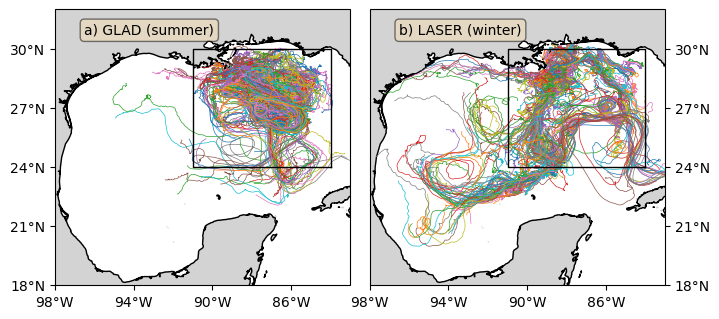

In [5]:
#### Plots area of study
import os
import cmocean
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

# Box limits
lonmin = -84
lonmax = -91
latmin = 24
latmax = 30

# Defining the figure
fg0, a0 = plt.subplots(1, 2, sharex=True, sharey=True,
                         figsize=(7, 7.3),
                         facecolor='w', edgecolor='k',
                         subplot_kw={'projection': ccrs.PlateCarree()})
fg0.subplots_adjust(wspace=0.3, hspace=0.02)

cs = np.linspace(0, 1.4, 50)

a0[0].set_extent([-97, -83, 18, 32], ccrs.PlateCarree())     
a0[0].plot(glad_x, glad_y, linewidth=0.5)
a0[0].plot([lonmin, lonmin, lonmax, lonmax, lonmin], [latmin, latmax, latmax, latmin, latmin], 
           linewidth=1, color='black', transform=ccrs.PlateCarree())
a0[0].text(0.1, 0.95, 'a) GLAD (summer)', transform=a0[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
a0[0].yaxis.tick_left()
a0[0].set_xticks(np.arange(-98, -83, 4), crs=ccrs.PlateCarree())
a0[0].set_yticks(np.arange(18, 32, 3), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
a0[0].xaxis.set_major_formatter(lon_formatter)
a0[0].yaxis.set_major_formatter(lat_formatter)
a0[0].set_xlabel('')
a0[0].set_ylabel('')
a0[0].set_title('')
a0[0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'))
a0[0].coastlines(linewidth=1)

a0[1].set_extent([-97, -83, 18, 32], ccrs.PlateCarree())     
a0[1].plot(laser_x, laser_y, linewidth=0.5)
a0[1].plot([lonmin, lonmin, lonmax, lonmax, lonmin], [latmin, latmax, latmax, latmin, latmin], 
           linewidth=1, color='black', transform=ccrs.PlateCarree())
a0[1].text(0.1, 0.95, 'b) LASER (winter)', transform=a0[1].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
a0[1].yaxis.tick_right()
a0[1].set_xticks(np.arange(-98, -83, 4), crs=ccrs.PlateCarree())
a0[1].set_yticks(np.arange(18, 32, 3), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
a0[1].xaxis.set_major_formatter(lon_formatter)
a0[1].yaxis.set_major_formatter(lat_formatter)
a0[1].set_xlabel('')
a0[1].set_ylabel('')
a0[1].set_title('')
a0[1].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'))
a0[1].coastlines(linewidth=1)

fg0.tight_layout(pad=0.001)

fg0.savefig('./FiguresMethodsPaper/fig_trajdrifters.png', bbox_inches = 'tight', format='png', dpi=500)

# Loads binned pairwise velocity fluctuation data

### GLAD: summertime experiment (60 days)

### LASER: wintertime experiment (90 days)

In [6]:
# Loads GLAD and LASER with bootstrapped data
import mat73 #library to ready -v7.3 MATLAB files

# Indices
indi = 5
indf = 28

glad_all = sp.io.loadmat('/data/SO3/manuelogv/MethodsKEFlux/pairs_sep_GLAD.mat')
glad_dul = glad_all['pairs_sep']['dul'][0, indi:indf]
glad_dut = glad_all['pairs_sep']['dut'][0, indi:indf]
dist_all = glad_all['dist_axis'][0, indi:indf]

laser_all = mat73.loadmat('/data/SO3/manuelogv/MethodsKEFlux/pairs_sep_LASER.mat')
laser_dul = np.array(laser_all['pairs_sep']['dul'][indi:indf], dtype=object)
laser_dut = np.array(laser_all['pairs_sep']['dut'][indi:indf], dtype=object)

In [7]:
from scipy.stats import kurtosis, skew
from joblib import Parallel, delayed  # For parallel processing

# Function to calculate the necessary statistics
def calculate_stats(du_glad, du_laser, du2_glad, du2_laser, du3_glad, du3_laser):
    glad_stats = {
        'mean': np.mean(du_glad),
        'std': np.std(du_glad),
        'skew': skew(du_glad),
        'kurt': kurtosis(du_glad, fisher=True)
    }
    
    laser_stats = {
        'mean': np.mean(du_laser),
        'std': np.std(du_laser),
        'skew': skew(du_laser),
        'kurt': kurtosis(du_laser, fisher=True)
    }

    glad_du2_stats = {
        'mean': np.mean(du2_glad),
        'std': np.std(du2_glad),
        'skew': skew(du2_glad),
        'kurt': kurtosis(du2_glad, fisher=True)
    }

    laser_du2_stats = {
        'mean': np.mean(du2_laser),
        'std': np.std(du2_laser),
        'skew': skew(du2_laser),
        'kurt': kurtosis(du2_laser, fisher=True)
    }

    glad_du3_stats = {
        'mean': np.mean(du3_glad),
        'std': np.std(du3_glad),
        'skew': skew(du3_glad),
        'kurt': kurtosis(du3_glad, fisher=True)
    }

    laser_du3_stats = {
        'mean': np.mean(du3_laser),
        'std': np.std(du3_laser),
        'skew': skew(du3_laser),
        'kurt': kurtosis(du3_laser, fisher=True)
    }

    return glad_stats, laser_stats, glad_du2_stats, laser_du2_stats, glad_du3_stats, laser_du3_stats


# Parallelize the processing of each index
def process_index(ii):
    du_glad = glad_dul[ii][:, 0] + glad_dut[ii][:, 0]
    du_laser = laser_dul[ii] + laser_dut[ii]
    
    du2_glad, du3_glad = SF2_3(glad_dul[ii][:, 0], glad_dut[ii][:, 0])
    du2_laser, du3_laser = SF2_3(laser_dul[ii], laser_dut[ii])

    return calculate_stats(du_glad, du_laser, du2_glad, du2_laser, du3_glad, du3_laser)

In [8]:
# Define number of CPU cores for parallelism
num_cores = 6  # Using all available cores (-1), you can set it to a specific number if preferred

# Using Parallel and delayed from joblib to process in parallel
results = Parallel(n_jobs=num_cores)(delayed(process_index)(ii) for ii in tqdm(range(len(dist_all))))

# Unpack results and store them in respective arrays
glad_du_mean, laser_du_mean = [], []
glad_du_std, laser_du_std = [], []
glad_du_skew, laser_du_skew = [], []
glad_du_kurt, laser_du_kurt = [], []
glad_du2_mean, laser_du2_mean = [], []
glad_du2_std, laser_du2_std = [], []
glad_du2_skew, laser_du2_skew = [], []
glad_du2_kurt, laser_du2_kurt = [], []
glad_du3_mean, laser_du3_mean = [], []
glad_du3_std, laser_du3_std = [], []
glad_du3_skew, laser_du3_skew = [], []
glad_du3_kurt, laser_du3_kurt = [], []

# Extract values from results and store them in arrays
for glad_stats, laser_stats, glad_du2_stats, laser_du2_stats, glad_du3_stats, laser_du3_stats in results:
    glad_du_mean.append(glad_stats['mean'])
    laser_du_mean.append(laser_stats['mean'])
    glad_du_std.append(glad_stats['std'])
    laser_du_std.append(laser_stats['std'])
    glad_du_skew.append(glad_stats['skew'])
    laser_du_skew.append(laser_stats['skew'])
    glad_du_kurt.append(glad_stats['kurt'])
    laser_du_kurt.append(laser_stats['kurt'])
    
    glad_du2_mean.append(glad_du2_stats['mean'])
    laser_du2_mean.append(laser_du2_stats['mean'])
    glad_du2_std.append(glad_du2_stats['std'])
    laser_du2_std.append(laser_du2_stats['std'])
    glad_du2_skew.append(glad_du2_stats['skew'])
    laser_du2_skew.append(laser_du2_stats['skew'])
    glad_du2_kurt.append(glad_du2_stats['kurt'])
    laser_du2_kurt.append(laser_du2_stats['kurt'])
    
    glad_du3_mean.append(glad_du3_stats['mean'])
    laser_du3_mean.append(laser_du3_stats['mean'])
    glad_du3_std.append(glad_du3_stats['std'])
    laser_du3_std.append(laser_du3_stats['std'])
    glad_du3_skew.append(glad_du3_stats['skew'])
    laser_du3_skew.append(laser_du3_stats['skew'])
    glad_du3_kurt.append(glad_du3_stats['kurt'])
    laser_du3_kurt.append(laser_du3_stats['kurt'])

# Convert the lists to numpy arrays for further use
glad_du_mean = np.array(glad_du_mean)
laser_du_mean = np.array(laser_du_mean)
glad_du_std = np.array(glad_du_std)
laser_du_std = np.array(laser_du_std)
glad_du_skew = np.array(glad_du_skew)
laser_du_skew = np.array(laser_du_skew)
glad_du_kurt = np.array(glad_du_kurt)
laser_du_kurt = np.array(laser_du_kurt)

glad_du2_mean = np.array(glad_du2_mean)
laser_du2_mean = np.array(laser_du2_mean)
glad_du2_std = np.array(glad_du2_std)
laser_du2_std = np.array(laser_du2_std)
glad_du2_skew = np.array(glad_du2_skew)
laser_du2_skew = np.array(laser_du2_skew)
glad_du2_kurt = np.array(glad_du2_kurt)
laser_du2_kurt = np.array(laser_du2_kurt)

glad_du3_mean = np.array(glad_du3_mean)
laser_du3_mean = np.array(laser_du3_mean)
glad_du3_std = np.array(glad_du3_std)
laser_du3_std = np.array(laser_du3_std)
glad_du3_skew = np.array(glad_du3_skew)
laser_du3_skew = np.array(laser_du3_skew)
glad_du3_kurt = np.array(glad_du3_kurt)
laser_du3_kurt = np.array(laser_du3_kurt)

  0%|          | 0/23 [00:00<?, ?it/s]

# Calculates first-order structure function $D1(r)$

#### Homogeneity condition: $D1(r)\sim 0$ 

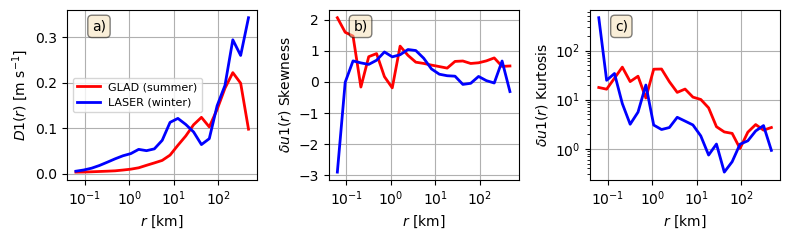

In [9]:
fig3, ax3 = plt.subplots(1, 3, figsize=(8, 2.5))

# du_mbins = 0.5*(du_bins[:-1] + du_bins[1:])
# ddu = np.mean(np.diff((du_mbins), axis=0))

distkm = dist_all*1e-3

ax3[0].semilogx(distkm, glad_du_mean, '-r', linewidth=2, label='GLAD (summer)')
ax3[0].plot(distkm, laser_du_mean, '-b', linewidth=2, label='LASER (winter)')
ax3[0].set_xlabel('$r$ [km]')
ax3[0].set_ylabel('$D1(r)$ [m s$^{-1}$]')
ax3[0].text(0.13, 0.88, 'a)', transform=ax3[0].transAxes, bbox=props)
ax3[0].legend(fontsize=8, loc=6)
ax3[0].set_xticks([1e-1, 1e0, 1e1, 1e2])
ax3[0].grid()

ax3[1].semilogx(distkm, glad_du_skew, '-r', linewidth=2)
ax3[1].plot(distkm, laser_du_skew, '-b', linewidth=2)
ax3[1].set_ylabel('$\\delta u1(r)$ Skewness')
ax3[1].set_xlabel('$r$ [km]')
ax3[1].text(0.13, 0.88, 'b)', transform=ax3[1].transAxes, bbox=props)
ax3[1].set_xticks([1e-1, 1e0, 1e1, 1e2])
ax3[1].grid()

ax3[2].loglog(distkm, glad_du_kurt, '-r', linewidth=2)
ax3[2].plot(distkm, laser_du_kurt, '-b', linewidth=2)
ax3[2].set_ylabel('$\\delta u1(r)$ Kurtosis')
ax3[2].set_xlabel('$r$ [km]')
ax3[2].text(0.13, 0.88, 'c)', transform=ax3[2].transAxes, bbox=props)
ax3[2].set_xticks([1e-1, 1e0, 1e1, 1e2])
ax3[2].grid()

fig3.tight_layout()
fig3.savefig('./FiguresMethodsPaper/fig_du1_meanskew_drifter_N.png', bbox_inches = 'tight', format='png', dpi=500)

# Estimates Rossby number, decorrelation time scale and degrees of freedom

\begin{equation}
    Ro(r) = \frac{\sqrt{D2(r)}}{fr}
\end{equation}


\begin{equation}
    T_{scale}(r) = \frac{r}{\sqrt{D2(r)}}
\end{equation}

\begin{equation}
    N(r) =\frac{T_{scale}(r)}{T_{tot}}
\end{equation}

In [10]:
import gsw

fcor = gsw.f(27) # Coriolis
Ttot_glad = 90*86400 # Total time GLAD in seconds
Ttot_laser = 60*86400 # Total time LASER in seconds

# T_scale
tcorr_glad = timescale(glad_du2_mean, dist_all)
tcorr_laser = timescale(laser_du2_mean, dist_all)

# Ro
ro_glad = rossby_r(glad_du2_mean, dist_all, fcor)
ro_laser = rossby_r(laser_du2_mean, dist_all, fcor)

# N
dof_glad = Ttot_glad/tcorr_glad
dof_laser = Ttot_laser/tcorr_laser

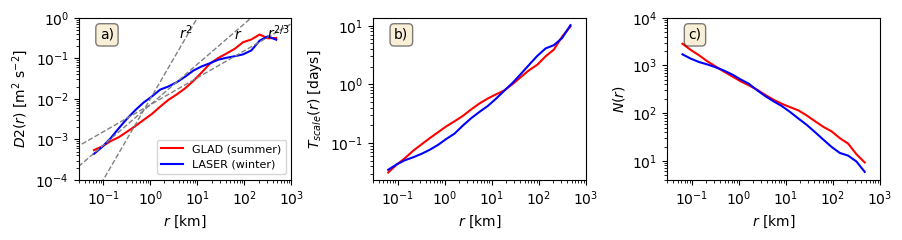

In [11]:
fig2, ax2 = plt.subplots(1, 3, figsize=(9, 2.5), sharex=True)

distkm = dist_all*1e-3

ax2[0].loglog(distkm, glad_du2_mean, 'r', label='GLAD (summer)')
ax2[0].loglog(distkm, laser_du2_mean, 'b', label='LASER (winter)')
ax2[0].set_ylabel('$D2(r)$ [m$^2$ s$^{-2}$]')
ax2[0].plot(np.arange(1e-2, 1e3, 10), np.arange(1e-2, 1e3, 10)**(2)/(1e2), '--', linewidth=1, color='gray')
ax2[0].plot(np.arange(1e-2, 1e3, 10), np.arange(1e-2, 1e3, 10)/1.4e2, '--', linewidth=1, color='gray')
ax2[0].plot(np.arange(1e-2, 1e3, 10), np.arange(1e-2, 1e3, 10)**(2/3)/1.4e2, '--', linewidth=1, color='gray')
ax2[0].text(4, 3e-1, '$r^2$')
ax2[0].text(0.6e2, 3e-1, '$r$')
ax2[0].text(3e2, 3e-1, '$r^{2/3}$')
ax2[0].set_xlim(3e-2, 1e3)
ax2[0].set_ylim(1e-4, 1e0)
ax2[0].legend(fontsize=8)
ax2[0].text(0.1, 0.87, 'a)', transform=ax2[0].transAxes, bbox=props)
ax2[0].set_xlabel('$r$ [km]')

ax2[1].loglog(distkm, tcorr_glad/86400, 'r')
ax2[1].loglog(distkm, tcorr_laser/86400, 'b')
ax2[1].set_xlabel('$r$ [km]')
ax2[1].set_ylabel('$T_{scale}(r)$ [days]')
ax2[1].text(0.1, 0.87, 'b)', transform=ax2[1].transAxes, bbox=props)


ax2[2].loglog(distkm, dof_glad, 'r')
ax2[2].loglog(distkm, dof_laser, 'b')
ax2[2].set_xlabel('$r$ [km]')
ax2[2].set_ylabel('$N(r)$')
ax2[2].text(0.1, 0.87, 'c)', transform=ax2[2].transAxes, bbox=props)
ax2[2].set_ylim(4e0, 1e4)

fig2.tight_layout()
fig2.savefig('./FiguresMethodsPaper/fig_du2_drifter_N.png', bbox_inches = 'tight', format='png', dpi=500)

# PDFs of $\delta u3(\mathbf{s}, \mathbf{r}, t)$ 

PDFs, kurtosis and skewness allow to estimate if $\delta u3(\mathbf{s}, \mathbf{r}, t)$ is Gaussian distributed. Regularized least-squares assumes that errors in $D3(r)$ are Gaussian distributed.

The third-order structure function is defined as an ensemble over all positions, orientations and times of $\delta u3(\mathbf{s}, \mathbf{r}, t)$:

\begin{equation}
    D3(r) = <\delta u3(\mathbf{s}, \mathbf{r}, t)> = <\delta u_L^3(\mathbf{s}, \mathbf{r}, t) + \delta u_T^2(\mathbf{s}, \mathbf{r}, t)\delta u_L(\mathbf{s}, \mathbf{r}, t)>
\end{equation}

In [12]:
# Estimates PDFs
from scipy.stats import norm

io = 7
ip = 20

# D1(r) and D3(r) for small-scale r
du_glad = glad_dul[io][:, 0] + glad_dut[io][:, 0]
du_laser = laser_dul[io] + laser_dut[io]
_, du3_glad = SF2_3(glad_dul[io][:, 0], glad_dut[io][:, 0])
_, du3_laser = SF2_3(laser_dul[io], laser_dut[io])

# D1(r) and D3(r) for large-scale r
du_glad0 = glad_dul[ip][:, 0] + glad_dut[ip][:, 0]
du_laser0 = laser_dul[ip] + laser_dut[ip]
_, du3_glad0 = SF2_3(glad_dul[ip][:, 0], glad_dut[ip][:, 0])
_, du3_laser0 = SF2_3(laser_dul[ip], laser_dut[ip])

du3x = 1

du_bins = np.arange(-130, 130, du3x) # du bins normalized standard deviation
du3_bins = np.arange(-130, 130, du3x) #du3 bins nomalized

# PDFs First-order structure function
cts_du_glad, bin_du = np.histogram(du_glad/np.std(du_glad), bins = du_bins, density=True)
cts_du_laser, _ = np.histogram(du_laser/np.std(du_laser), bins = du_bins, density=True)
cts_du_glad0, _ = np.histogram(du_glad0/np.std(du_glad0), bins = du_bins, density=True)
cts_du_laser0, _ = np.histogram(du_laser0/np.std(du_laser0), bins = du_bins, density=True)

# PDFs Third-order structure function
cts_du3_glad, bin_du = np.histogram(du3_glad/np.std(du3_glad), bins = du3_bins, density=True)
cts_du3_laser, _ = np.histogram(du3_laser/np.std(du3_laser), bins = du3_bins, density=True)
cts_du3_glad0, _ = np.histogram(du3_glad0/np.std(du3_glad0), bins = du3_bins, density=True)
cts_du3_laser0, _ = np.histogram(du3_laser0/np.std(du3_laser0), bins = du3_bins, density=True)


# Constructs Gaussian third-order structure function
glad_norm = norm.pdf(du3_bins, np.mean(du3_glad)/np.std(du3_glad), 1)
glad0_norm = norm.pdf(du3_bins, np.mean(du3_glad0)/np.std(du3_glad0), 1)
laser_norm = norm.pdf(du3_bins, np.mean(du3_laser)/np.std(du3_laser), 1)
laser0_norm = norm.pdf(du3_bins, np.mean(du3_laser0)/np.std(du3_laser0), 1)

1.0
0.9999999999999999
1.0
1.0


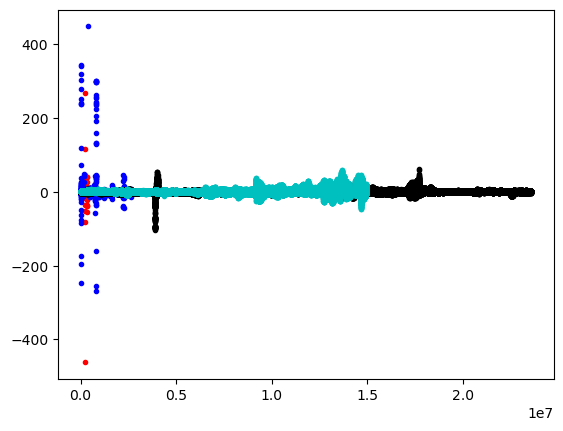

In [13]:
# Checks that sum of probabilities is = 1

print(np.sum(cts_du_glad*du3x))
print(np.sum(cts_du_laser*du3x))
print(np.sum(cts_du3_glad*du3x))
print(np.sum(cts_du3_laser*du3x))

plt.plot(du3_glad/np.std(du3_glad), '.r')
plt.plot(du3_laser/np.std(du3_laser), '.b')
plt.plot(du3_glad0/np.std(du3_glad0), '.k')
plt.plot(du3_laser0/np.std(du3_laser0), '.c')

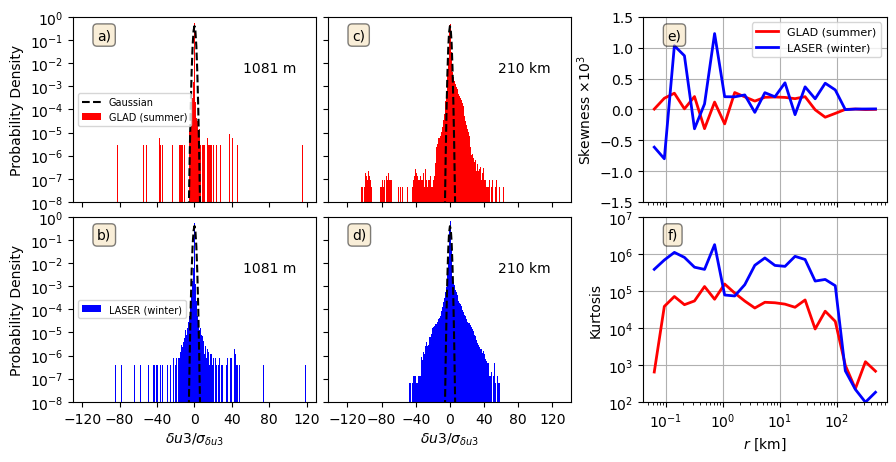

In [14]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker


fig4, ax4 = plt.subplots(2, 4, figsize=(10.5, 5), gridspec_kw={'width_ratios': [1, 1, 0.2, 1]})

du3_mbins = 0.5*(du3_bins[:-1] + du3_bins[1:])
ddu3 = np.mean(np.diff((du3_mbins), axis=0))

# ytickslog = np.logspace(-5, 2, num=7)


ax4[0, 0].bar(du3_mbins, cts_du3_glad, color='r', edgecolor=None,
              width=du3x, alpha=1, label='GLAD (summer)')
ax4[0, 0].plot(du3_bins, glad_norm, '--k', label='Gaussian')
ax4[0, 0].set_yscale('log')
ax4[0, 0].set_xticks(np.arange(-120, 140, 40))
# ax4[0, 0].set_yticks(ytickslog)
ax4[0, 0].set_xlim(-130, 130)
ax4[0, 0].set_xticklabels([])
ax4[0, 0].legend(fontsize=7, loc=6)
ax4[0, 0].set_ylabel('Probability Density')
ax4[0, 0].text(0.1, 0.88, 'a)', transform=ax4[0, 0].transAxes, bbox=props)
ax4[0, 0].text(0.7, 0.7, "{} m".format(round(dist_all[io])), transform=ax4[0, 0].transAxes)
ax4[0, 0].yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))
ax4[0, 0].set_ylim(1e-8, 1e0)

ax4[1, 0].bar(du3_mbins, cts_du3_laser, color='b', edgecolor=None,
              width=du3x, alpha=1, label='LASER (winter)')
ax4[1, 0].plot(du3_bins, laser_norm, '--k')
ax4[1, 0].set_yscale('log')
ax4[1, 0].set_xticks(np.arange(-120, 140, 40))
# ax4[1, 0].set_yticks(ytickslog)
ax4[1, 0].set_xlim(-130, 130)
ax4[1, 0].legend(fontsize=7, loc=6)
ax4[1, 0].set_ylabel('Probability Density')
ax4[1, 0].text(0.1, 0.88, 'b)', transform=ax4[1, 0].transAxes, bbox=props)
ax4[1, 0].text(0.7, 0.7, "{} m".format(round(dist_all[io])), transform=ax4[1, 0].transAxes)
ax4[1, 0].set_xlabel('$\\delta u3/\\sigma_{\\delta u3}$')
ax4[1, 0].yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))
ax4[1, 0].set_ylim(1e-8, 1e0)


ax4[0, 1].bar(du3_mbins, cts_du3_glad0, color='r', edgecolor=None,
              width=du3x, alpha=1, label='GLAD (summer)')
ax4[0, 1].plot(du3_bins, glad0_norm, '--k', label='Gaussian fit')
ax4[0, 1].set_yscale('log')
# ax4[0, 1].set_ylim(1e-5, 3e2)
# ax4[0, 1].set_yticks(ytickslog)
ax4[0, 1].set_xticks(np.arange(-120, 140, 40))
ax4[0, 1].set_xticklabels([])
ax4[0, 1].set_yticklabels([])
# ax4[0, 1].set_xlim(-45, 45)
# ax4[0, 1].legend(fontsize=8, loc=2)
ax4[0, 1].text(0.1, 0.88, 'c)', transform=ax4[0, 1].transAxes, bbox=props)
ax4[0, 1].text(0.7, 0.7, "{} km".format(round(distkm[ip])), transform=ax4[0, 1].transAxes)
ax4[0, 1].yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))
ax4[0, 1].set_ylim(1e-8, 1e0)


ax4[1, 1].bar(du3_mbins, cts_du3_laser0, color='b', edgecolor=None,
              width=du3x, alpha=1, label='LASER (winter)')
ax4[1, 1].plot(du3_bins, laser0_norm, '--k')
ax4[1, 1].set_yscale('log')
# ax4[1, 1].set_ylim(1e-5, 3e2)
# ax4[1, 1].set_yticks(ytickslog)
ax4[1, 1].set_xticks(np.arange(-120, 140, 40))
ax4[1, 1].set_yticklabels([])
# ax4[1, 1].set_xlim(-45, 45)
# ax4[1, 1].legend(fontsize=8, loc=2)
ax4[1, 1].text(0.1, 0.88, 'd)', transform=ax4[1, 1].transAxes, bbox=props)
ax4[1, 1].text(0.7, 0.7, "{} km".format(round(distkm[ip])), transform=ax4[1, 1].transAxes)
ax4[1, 1].set_xlabel('$\\delta u3/\\sigma_{\\delta u3}$')
ax4[1, 1].yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))
ax4[1, 1].set_ylim(1e-8, 1e0)


ax4[0, 3].semilogx(distkm, glad_du3_skew*1e-3, '-r', linewidth=2, label='GLAD (summer)')
ax4[0, 3].plot(distkm, laser_du3_skew*1e-3, '-b', linewidth=2, label='LASER (winter)')
ax4[0, 3].set_ylim(-1.5, 1.5)
ax4[0, 3].set_ylabel('Skewness $\\times 10^{3}$')
# ax4[0, 2].set_xlabel('$r$ [km]')
ax4[0, 3].set_xticklabels([])
ax4[0, 3].text(0.1, 0.88, 'e)', transform=ax4[0, 3].transAxes, bbox=props)
ax4[0, 3].legend(fontsize=8)
ax4[0, 3].grid()
                     
ax4[1, 3].loglog(distkm, glad_du3_kurt, '-r', linewidth=2)
ax4[1, 3].plot(distkm, laser_du3_kurt, '-b', linewidth=2)
ax4[1, 3].set_ylim(1e2, 1e7)
ax4[1, 3].yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))
ax4[1, 3].set_ylabel('Kurtosis')
ax4[1, 3].set_xlabel('$r$ [km]')
ax4[1, 3].text(0.1, 0.88, 'f)', transform=ax4[1, 3].transAxes, bbox=props)
ax4[1, 3].grid()

ax4[0, 2].set_visible(False)
ax4[1, 2].set_visible(False)


fig4.subplots_adjust(hspace=0.08, wspace=0.06)
fig4.savefig('./FiguresMethodsPaper/fig_du3_hist_drifter_N.png', bbox_inches = 'tight', format='png', dpi=500)

# KE transfers (fluxes)

$D3(r)$ is related to azimuthally averaged 2D cross-scale KE transfers $F(k)$ through the following relationship (i.e., a Hankel transform):
%
\begin{equation}
    D3(r)=-4r\int^\infty_0 \frac{1}{k}F(k)J_2(kr)dk, \label{eq7}\\
\end{equation}
%
where $J_2$ is the second-order Bessel function \citep{xie2019third}. $F(k)>0$ indicates a forward cascade (i.e., KE transfer towards smaller scales); conversely, $F(k)<0$ indicates an inverse cascade (towards larger scales). 

\cite{balwada2022direct} suggest that a convenient way to discretize the spectral flux is by using a basis formed by step functions as
%
\begin{equation}
    F(k)=-\epsilon_u + \sum^{N_k}_{j=1} \epsilon_j H(k-k_j)dk_j, \label{eq9}
\end{equation}
%
where $\epsilon_u$ and $\epsilon_j dk_j=\epsilon_u + \epsilon_d$ can be physically interpreted as the upscale and total KE injection ($\epsilon_d>0$ is the downscale energy transfer), $ H$ is the Heaviside function, and $N_k$ represents the number of discrete wavenumbers that are chosen. Substituting (\ref{eq9}) in (\ref{eq7}) yields
%
\begin{equation}
    D3(r)= 2\epsilon_u r - \sum^{N_k}_{j=1} 4\frac{\epsilon_j}{k_j}J_1(k_jr)dk_j. \label{eq10}
\end{equation}

This equation provides the starting point for a discrete linear inverse problem, where the goal is to estimate $\epsilon_u$ and $\epsilon_j$ at a selected range of $k_j$ from an estimated $D3(r)$.

### NON-NEGATIVE LEAST SQUARES

NNLS method inherently cannot capture negative KE injection rates (indicative of KE transfer convergence). As a result, the derived KE transfers are strictly increasing with wavenumber — an assumption that may not hold universally, such as during the conversion of KE to potential energy.

To estimate confidence intervals, we use bootstrapping to estimate 1000 bootstrapped $D3(r)$ samples and invert them using NNLS. The uncertainty in $F(k)$ and $\epsilon_j$ is calculated as the standard deviation of the 1000 inverted quantities.

In [15]:
from joblib import Parallel, delayed

# Parameters
nsampls = 1000
max_cores = 20
rndmst = np.random.default_rng()

def custom_bootstrap(data, n_resamples, random_state):
    """
    Perform custom bootstrap resampling for the mean.
    data: Original data array
    n_resamples: Number of bootstrap resamples
    random_state: Random state object for reproducibility
    """
    # Initialize an array to store the means of the resampled data
    means = np.zeros(n_resamples)
    
    # Perform bootstrapping
    for i in range(n_resamples):
        # Resample with replacement
        resample = random_state.choice(data, size=len(data), replace=True)
        means[i] = np.mean(resample)
    
    return means

def process_bootstrap(ii, nsampls, rndmst, dist_all, glad_dul, glad_dut, laser_dul, laser_dut):
    # Calculates du3
    _, du3_glad = SF2_3(glad_dul[ii][:, 0], glad_dut[ii][:, 0]) # LASER
    _, du3_laser = SF2_3(laser_dul[ii], laser_dut[ii]) # GLAD
    
    # Bootstrapping du3_glad
    datag = du3_glad
    datal = du3_laser

    # Perform custom bootstrapping for mean calculation
    resultg = custom_bootstrap(datag, nsampls, rndmst)
    resultl = custom_bootstrap(datal, nsampls, rndmst)

    return resultg, resultl  # Return results instead of modifying globals

def run_parallel_bootstrap(nsampls, rndmst, dist_all, glad_dul, glad_dut, laser_dul, laser_dut):
    # Parallelize the for loop using joblib and collect results
    results = Parallel(n_jobs=max_cores)(
        delayed(process_bootstrap)(ii, nsampls, rndmst, dist_all, glad_dul, glad_dut, laser_dul, laser_dut)
        for ii in tqdm(range(len(dist_all)))
    )
    
    # Convert the results into arrays
    du3_glad_bstr = np.array([result[0] for result in results])
    du3_laser_bstr = np.array([result[1] for result in results])
    
    return du3_glad_bstr, du3_laser_bstr

# Running the parallel version
du3_glad_bstr, du3_laser_bstr = run_parallel_bootstrap(nsampls, rndmst, dist_all, glad_dul, glad_dut, laser_dul, laser_dut)


  0%|          | 0/23 [00:00<?, ?it/s]

(23, 1000)


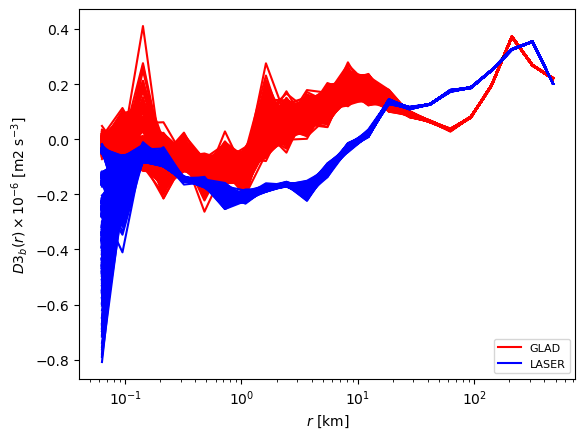

In [16]:
plt.semilogx(distkm, du3_glad_bstr/dist_all[:, None]*1e6, 'r')
plt.semilogx(distkm, du3_laser_bstr/dist_all[:, None]*1e6, 'b')
plt.semilogx(distkm[0], du3_glad_bstr[0, 0]/dist_all[0], 'r', label='GLAD')
plt.semilogx(distkm[0], du3_laser_bstr[0, 0]/dist_all[0], 'b', label='LASER')
plt.ylabel('$D3_b(r) \\times 10^{-6}$ [m$2$ s$^{-3}$]')
plt.xlabel('$r$ [km]')
plt.legend(fontsize=8)
print(du3_glad_bstr.shape)

In [17]:
# Non-negative inversion
from scipy.optimize import nnls

kbins_nn = np.logspace(np.log10(1/max(dist_all)), np.log10(1/min(dist_all)), len(dist_all)-1) ;
dk_nn = np.diff(kbins_nn)
kbins_nn = 0.5*(kbins_nn[0:-1] + kbins_nn[1:])

rmat, kmat = np.meshgrid(dist_all, np.arange(0, len(kbins_nn)+1))

# Define model matrix
Ann = defA(dist_all, kbins_nn, dk_nn)/rmat.T

fk_glad_nn = np.zeros((len(kbins_nn), nsampls))
fk_laser_nn = np.zeros((len(kbins_nn), nsampls))

eps_glad_nn = np.zeros((len(kbins_nn)+1, nsampls))
eps_laser_nn = np.zeros((len(kbins_nn)+1, nsampls))
sf3_glad_nn = np.zeros((len(dist_all), nsampls))
sf3_laser_nn = np.zeros((len(dist_all), nsampls))


for ii in tqdm(range(du3_glad_bstr.shape[1])):
    
    # Non-negative least-squares (values of eps cannot be negative)
    eps_glad_nn[:, ii] = nnls(Ann, du3_glad_bstr[:, ii]/dist_all)[0]    
    eps_laser_nn[:, ii] = nnls(Ann, du3_laser_bstr[:, ii]/dist_all)[0]    
    sf3_glad_nn[:, ii] = np.matmul(Ann, eps_glad_nn[:, ii])
    sf3_laser_nn[:, ii] = np.matmul(Ann, eps_laser_nn[:, ii])
    
    # cross-scale transfers
    fk_glad_nn[:, ii] = calcFk(eps_glad_nn[:, ii], kbins_nn, dk_nn)
    fk_laser_nn[:, ii] = calcFk(eps_laser_nn[:, ii], kbins_nn, dk_nn)
    
# Errors
err_eps_glad_nn = np.std(eps_glad_nn, axis=1)
err_eps_laser_nn = np.std(eps_laser_nn, axis=1)
err_fk_glad_nn = np.std(fk_glad_nn, axis=1)
err_fk_laser_nn = np.std(fk_laser_nn, axis=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

### REGULARIZED LEAST-SQUARES

Regularized least-squares requires that $\mathbf{x}$ and $\mathbf{e}$ (\ref{eq11}) have Gaussian distributions. The most probable model solutions are given by 
%
\begin{equation}
    \widetilde{\mathbf{x}} = \big(\mathbf{H}^\text{T} \mathbf{W}^{-1} \mathbf{H} + \mathbf{P}^{-1}\big)^{-1} \mathbf{H}^\text{T} \mathbf{W}^{-1} \mathbf{y}, \label{eq13} \\
\end{equation}
%
where $\widetilde{\mathbf{x}}$ is the column vector of size $M \times 1$ (where $M=N_k+1$) representing the fitted parameters ($\epsilon_u$ and $\epsilon_j$s), $\mathbf{y}$ is the vector of data to fit (i.e., $D3(r)$) of size $N_r$ (number of discrete $r$ bins), $\mathbf{e}$ is the residual, and $\mathbf{H}$ is the model matrix of size $N_r \times M$, $\mathbf{W}=\langle\mathbf{e}\mathbf{e}^\text{T}\rangle$ is the data covariance matrix representing the prior data uncertainty and is of size $N_r\times N_r$; $\mathbf{P}=\langle\mathbf{x}\mathbf{x}^\text{T}\rangle$ is the covariance matrix representing the prior uncertainty of the fitted parameters and is $M \times M$ \citep{kacheleinetal2022, wunsch1996}.

##### For $\mathbf{W}$ we use the squared of the prior uncertainty in $D3(r)$ calculated as the standard error of the bootstrapped samples $D3_b(r)$

In [18]:
# Regularized least-squares 
# Uses same kbins and dk used in NNLS

kbins_rls = kbins_nn
dk_rls = dk_nn
Arls = defA(dist_all, kbins_rls, dk_rls)

# Define weight matrix
W_glad = np.diag(glad_du3_std**2/dof_glad)#[indi:indf])
W_laser = np.diag(laser_du3_std**2/dof_laser)#[indi:indf])

fac = 1e-2
fac_epsj = 0.3e-3

# A priori errors
P_glad = np.concatenate(([fac], np.ones((len(kbins_rls),))*fac_epsj), axis=0)
P_glad = np.diag(P_glad)

P_laser = np.concatenate(([fac], np.ones((len(kbins_rls),))*fac_epsj), axis=0)
P_laser = np.diag(P_laser)

# Least squares
eps_glad_rls, V3_glad_rls, res_glad_rls, cxx_glad_rls = RLS(glad_du3_mean, W_glad, P_glad, Arls)    
eps_laser_rls, V3_laser_rls, res_laser_rls, cxx_laser_rls = RLS(laser_du3_mean, W_laser, P_laser, Arls)

# Injection rates errors
eps_err_glad_rls = np.sqrt(np.diag(cxx_glad_rls))
eps_err_laser_rls = np.sqrt(np.diag(cxx_laser_rls))

# Cross-scale transfers
fk_glad_rls = calcFk(eps_glad_rls, kbins_rls, dk_rls)
fk_laser_rls = calcFk(eps_laser_rls, kbins_rls, dk_rls)

# Energy flux errors
Herr_rls = defH(kbins_rls, dk_rls)
fk_err_glad_rls = np.sqrt(np.diag(errorsFlux(cxx_glad_rls, Herr_rls)))
fk_err_laser_rls = np.sqrt(np.diag(errorsFlux(cxx_laser_rls, Herr_rls)))

eigval_cxx_glad_rls, eigvec_cxx_glad_rls = np.linalg.eig(cxx_glad_rls)
eigval_cxx_laser_rls, eigvec_cxx_laser_rls = np.linalg.eig(cxx_laser_rls)

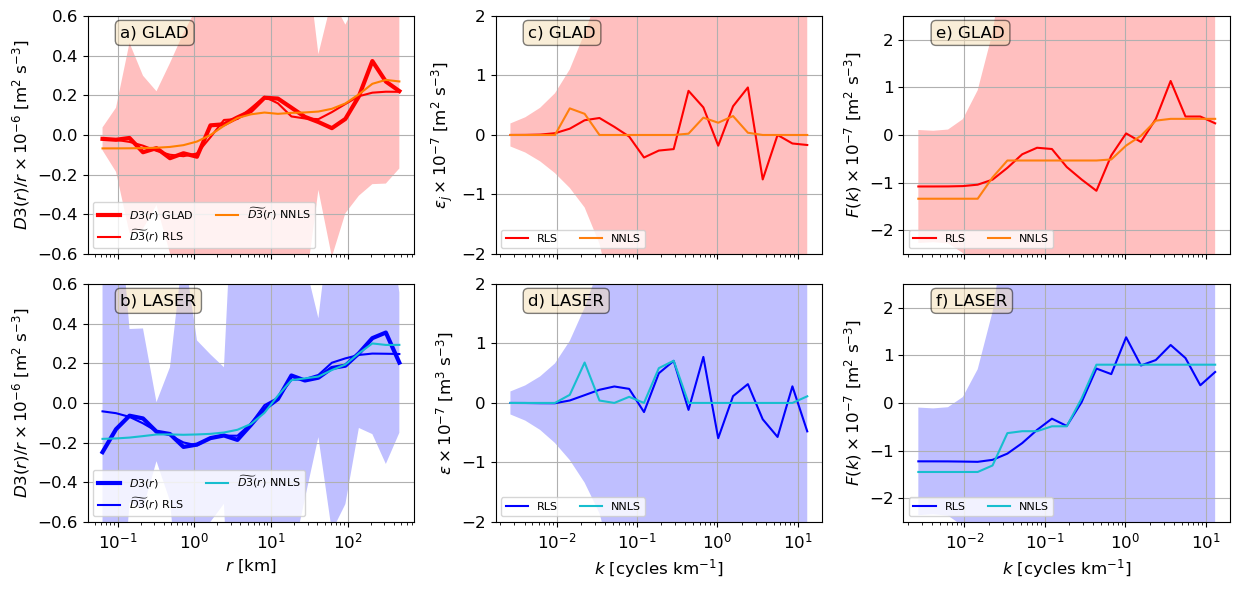

In [19]:
# Plots Paper figure

fg0, a0 = plt.subplots(2, 3, figsize=(12.5, 6))
a0[0, 0].semilogx(distkm, glad_du3_mean/dist_all*1e6, 
                  '-r', label='$D3(r)$ GLAD', linewidth=3)
a0[0, 0].fill_between(distkm, 1e6*(glad_du3_mean + glad_du3_std/np.sqrt(dof_glad))/dist_all, 
                      1e6*(glad_du3_mean - glad_du3_std/np.sqrt(dof_glad))/dist_all, 
                      color='r', alpha=0.25, edgecolor=None)
a0[0, 0].semilogx(distkm, V3_glad_rls/dist_all*1e6, '-r', label='$\\widetilde{D3}(r)$ RLS')
a0[0, 0].semilogx(distkm, np.nanmean(sf3_glad_nn, axis=1)*1e6, 
               '-', color='#ff7f00', label='$\\widetilde{D3}(r)$ NNLS')
a0[0, 0].set_ylabel('$D3(r)/r \\times 10^{-6}$ [m$^2$ s$^{-3}$]', fontsize=12)
a0[0, 0].set_xticklabels([])
a0[0, 0].text(0.1, 0.91, 'a) GLAD', transform=a0[0, 0].transAxes, bbox=props, fontsize=12)
a0[0, 0].tick_params(labelsize=12)
a0[0, 0].set_ylim(-0.6, 0.6)
a0[0, 0].legend(fontsize=8, loc=3, ncol=2)
a0[0, 0].grid()

a0[1, 0].semilogx(distkm, laser_du3_mean/dist_all*1e6, '-b', label='$D3(r)$', linewidth=3)
a0[1, 0].fill_between(distkm, 1e6*(laser_du3_mean + laser_du3_std/np.sqrt(dof_laser))/dist_all, 
                      1e6*(laser_du3_mean - laser_du3_std/np.sqrt(dof_laser))/dist_all, color='b',
                      alpha=0.25, edgecolor=None)
a0[1, 0].semilogx(distkm, V3_laser_rls/dist_all*1e6, '-b', label='$\\widetilde{D3}(r)$ RLS')
a0[1, 0].semilogx(distkm, np.nanmean(sf3_laser_nn, axis=1)*1e6, 
                  '-', color='#17BECF', label='$\\widetilde{D3}(r)$ NNLS')
a0[1, 0].set_ylabel('$D3(r)/r \\times 10^{-6}$ [m$^2$ s$^{-3}$]', fontsize=12)
a0[1, 0].set_xlabel('$r$ [km]', fontsize=12)
a0[1, 0].text(0.1, 0.91, 'b) LASER', transform=a0[1, 0].transAxes, bbox=props, fontsize=12)
a0[1, 0].tick_params(labelsize=12)
a0[1, 0].set_ylim(-0.6, 0.6)
a0[1, 0].legend(fontsize=8, loc=3, ncol=2)
a0[1, 0].grid()



a0[0, 1].semilogx(kbins_rls*1e3, eps_glad_rls[1:]*dk_rls*1e7, '-r', label='RLS')
a0[0, 1].fill_between(kbins_rls*1e3, 1e7*(eps_glad_rls[1:] - eps_err_glad_rls[1:])*dk_rls,
                      1e7*(eps_glad_rls[1:] + eps_err_glad_rls[1:])*dk_rls, color='red', alpha=0.25,
                      edgecolor=None)
a0[0, 1].semilogx(kbins_nn*1e3, 1e7*np.nanmean(eps_glad_nn[1:, :], axis=1)*dk_nn, '-', 
                  color='#FF7F0E', label='NNLS')
a0[0, 1].set_ylabel('$\\epsilon_j\\times 10^{-7}$ [m$^2$ s$^{-3}$]', fontsize=12)
a0[0, 1].set_xticklabels([])
a0[0, 1].tick_params(labelsize=12)
a0[0, 1].text(0.1, 0.91, 'c) GLAD', transform=a0[0, 1].transAxes, bbox=props, fontsize=12)
a0[0, 1].legend(fontsize=8, loc=3, ncol=2)
a0[0, 1].set_ylim(-2, 2)
a0[0, 1].grid()

a0[1, 1].semilogx(kbins_rls*1e3, eps_laser_rls[1:]*dk_rls*1e7, '-b', label='RLS')
a0[1, 1].fill_between(kbins_rls*1e3, 1e7*(eps_laser_rls[1:] - eps_err_laser_rls[1:])*dk_rls,
                      1e7*(eps_laser_rls[1:] + eps_err_laser_rls[1:])*dk_rls, color='blue', alpha=0.25,
                      edgecolor=None)
a0[1, 1].semilogx(kbins_nn*1e3, 1e7*np.nanmean(eps_laser_nn[1:, :], axis=1)*dk_nn, '-', 
                  color='#17BECF', label='NNLS')
a0[1, 1].set_ylabel('$\\epsilon\\times 10^{-7}$ [m$^3$ s$^{-3}$]', fontsize=12)
a0[1, 1].set_xlabel('$k$ [cycles km$^{-1}$]', fontsize=12)
a0[1, 1].tick_params(labelsize=12)
a0[1, 1].text(0.1, 0.91, 'd) LASER', transform=a0[1, 1].transAxes, bbox=props, fontsize=12)
a0[1, 1].legend(fontsize=8, loc=3, ncol=2)
a0[1, 1].set_ylim(-2, 2)
a0[1, 1].grid()


a0[0, 2].semilogx(kbins_rls*1e3, fk_glad_rls*1e7, '-r', label='RLS')
a0[0, 2].fill_between(kbins_rls*1e3, 1e7*(fk_glad_rls + fk_err_glad_rls), 1e7*(fk_glad_rls - fk_err_glad_rls),
                      color='red', alpha=0.25, edgecolor=None)
a0[0, 2].semilogx(kbins_nn*1e3, np.nanmean(fk_glad_nn, axis=1)*1e7, '-', 
                  color='#FF7F0E', label='NNLS')
a0[0, 2].set_ylabel('$F(k) \\times 10^{-7}$ [m$^2$ s$^{-3}$]', fontsize=12)
a0[0, 2].set_xticklabels([])
a0[0, 2].text(0.1, 0.91, 'e) GLAD', transform=a0[0, 2].transAxes, bbox=props, fontsize=12)
a0[0, 2].tick_params(labelsize=12)
a0[0, 2].legend(fontsize=8, loc=3, ncol=2)
a0[0, 2].set_ylim(-2.5, 2.5)
a0[0, 2].grid()


a0[1, 2].semilogx(kbins_rls*1e3, fk_laser_rls*1e7, '-b', label='RLS')
a0[1, 2].fill_between(kbins_rls*1e3, 1e7*(fk_laser_rls + fk_err_laser_rls), 
                      1e7*(fk_laser_rls - fk_err_laser_rls),
                      color='blue', alpha=0.25, edgecolor=None)
a0[1, 2].semilogx(kbins_nn*1e3, np.nanmean(fk_laser_nn, axis=1)*1e7, '-', 
                  color='#17BECF', label='NNLS')
a0[1, 2].set_ylabel('$F(k) \\times 10^{-7}$ [m$^2$ s$^{-3}$]', fontsize=12)
a0[1, 2].set_xlabel('$k$ [cycles km$^{-1}$]', fontsize=12)
a0[1, 2].text(0.1, 0.91, 'f) LASER', transform=a0[1, 2].transAxes, bbox=props, fontsize=12)
a0[1, 2].tick_params(labelsize=12)
a0[1, 2].legend(fontsize=8, loc=3, ncol=2)
a0[1, 2].set_ylim(-2.5, 2.5)
a0[1, 2].grid()


fg0.tight_layout()
fg0.savefig('./FiguresMethodsPaper/fig_du3_fk_drifter_N.png', bbox_inches = 'tight', format='png', dpi=500)

Assuming that errors in $D3(r)$ are Gaussian distributed, the standard errors are up to one order of magnitude larger than $D3(r)$.

Though RLS-based $\epsilon_j$ and $F(k)$ show similar results than the NNLS-based estimates (a bi-directional cascade that is modulated seasonally), they are noiser and with large posterior uncertainty.

##### TESTS CHECKING EIGENVALUES AND EIGENVECTORS, AND OTHER METRICS

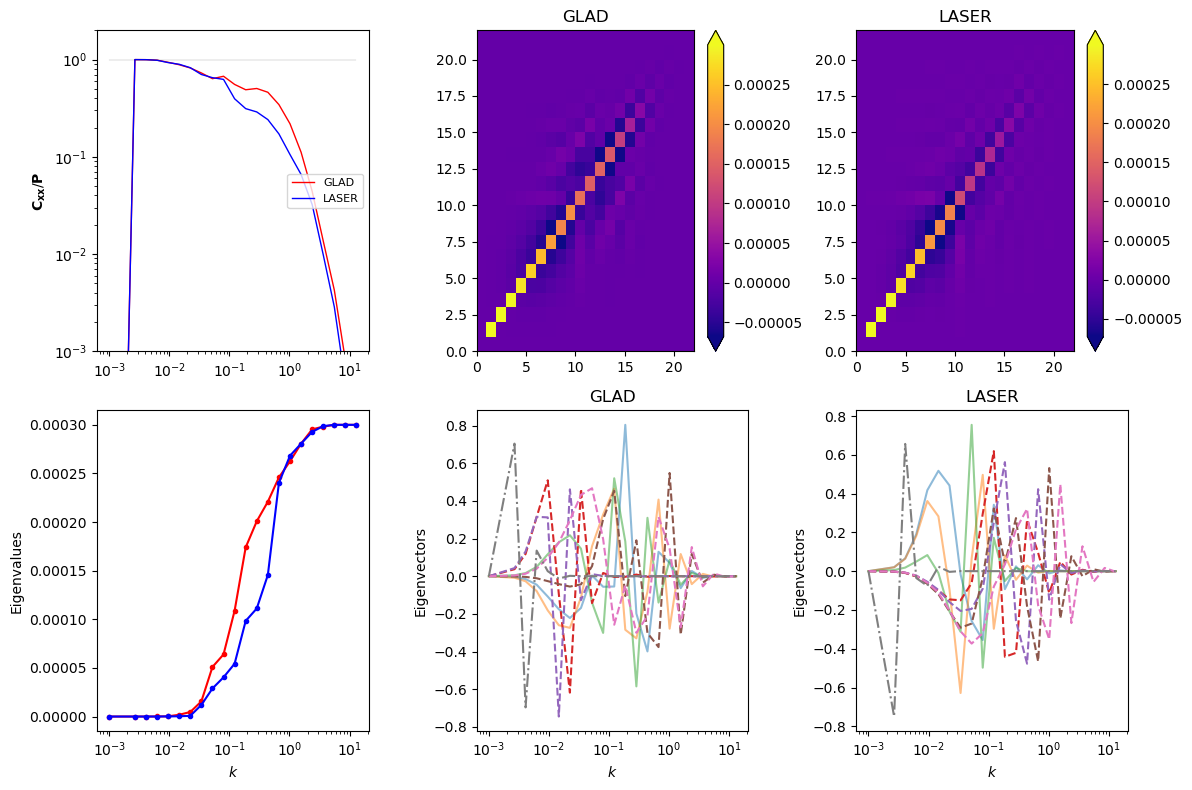

In [20]:
fig4, ax4 = plt.subplots(2, 3, figsize=(12, 8))

x1, x2 = np.meshgrid(np.concatenate(([1e-6], kbins_rls)), np.concatenate(([1e-6], kbins_rls)))

ax4[0, 0].loglog(np.concatenate(([1e-6], kbins_rls))*1e3, np.diag(cxx_glad_rls)/np.diag(P_glad), '-r', 
                 linewidth=1, label='GLAD')
ax4[0, 0].loglog(np.concatenate(([1e-6], kbins_rls))*1e3, np.diag(cxx_laser_rls)/np.diag(P_laser), '-b', 
                 linewidth=1, label='LASER')
ax4[0, 0].loglog([1e-3, max(kbins_rls)*1e3], [1, 1], color='black', linewidth=0.1)
ax4[0, 0].set_ylabel('$\\mathbf{C_{xx}}/\\mathbf{P}$')
ax4[0, 0].set_ylim(1e-3, 2e0)
ax4[0, 0].legend(fontsize=8, loc=5)

cs1 = ax4[0, 1].pcolormesh(cxx_glad_rls, cmap='plasma')
ax4[0, 1].set_title('GLAD')
plt.colorbar(cs1, ax=ax4[0, 1], extend='both')

cs2 = ax4[0, 2].pcolormesh(cxx_laser_rls, cmap='plasma')
ax4[0, 2].set_title('LASER')
plt.colorbar(cs2, ax=ax4[0, 2], extend='both')

ax4[1, 0].plot(np.concatenate(([1e-6], kbins_rls))*1e3, np.sort(eigval_cxx_glad_rls), '.-r')
ax4[1, 0].plot(np.concatenate(([1e-6], kbins_rls))*1e3, np.sort(eigval_cxx_laser_rls), '.-b')
ax4[1, 0].set_xscale('log')
ax4[1, 0].set_ylabel('Eigenvalues')
ax4[1, 0].set_xlabel('$k$')

ax4[1, 1].semilogx(np.concatenate(([1e-6], kbins_rls))*1e3, eigvec_cxx_glad_rls[:, :3], '-', alpha=0.5)
ax4[1, 1].semilogx(np.concatenate(([1e-6], kbins_rls))*1e3, eigvec_cxx_glad_rls[:, 6:10], '--')
ax4[1, 1].semilogx(np.concatenate(([1e-6], kbins_rls))*1e3, eigvec_cxx_glad_rls[:, -1], '-.')
ax4[1, 1].set_ylabel('Eigenvectors')
ax4[1, 1].set_xlabel('$k$')
ax4[1, 1].set_title('GLAD')

ax4[1, 2].semilogx(np.concatenate(([1e-6], kbins_rls))*1e3, eigvec_cxx_laser_rls[:, :3], '-', alpha=0.5)
ax4[1, 2].semilogx(np.concatenate(([1e-6], kbins_rls))*1e3, eigvec_cxx_laser_rls[:, 6:10], '--')
ax4[1, 2].semilogx(np.concatenate(([1e-6], kbins_rls))*1e3, eigvec_cxx_laser_rls[:, -1], '-.')
ax4[1, 2].set_ylabel('Eigenvectors')
ax4[1, 2].set_xlabel('$k$')
ax4[1, 2].set_title('LASER')

fig4.tight_layout()

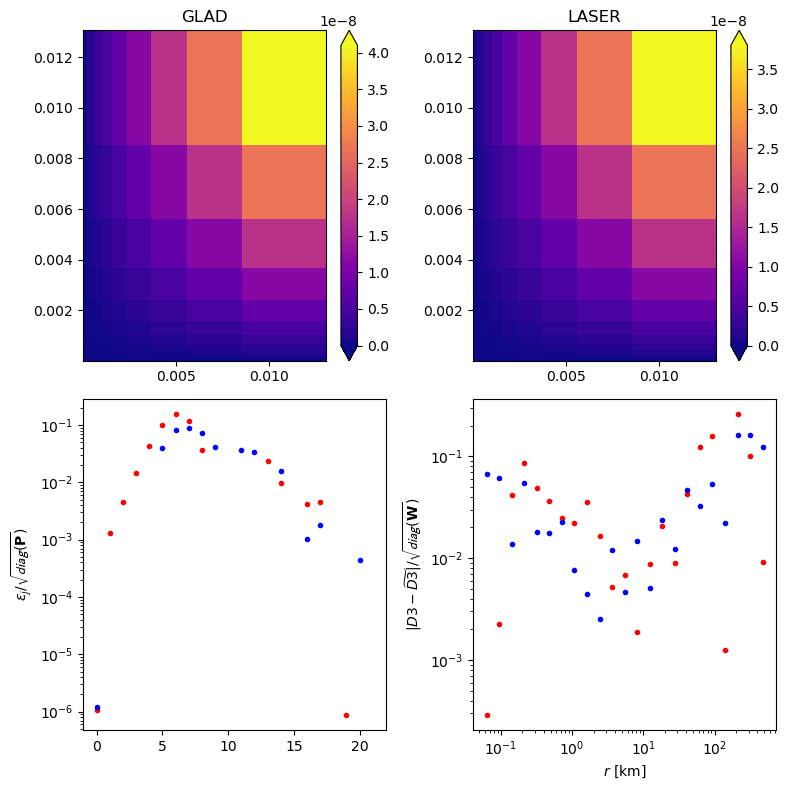

In [21]:
### CHECKING ERROR PROPAGATION 

fig5, ax5 = plt.subplots(2, 2, figsize=(8, 8), sharex=False, sharey=False)
cm1 = ax5[0, 0].pcolormesh(x1, x2, errorsFlux(cxx_glad_rls, Herr_rls), cmap='plasma')
plt.colorbar(cm1, ax=ax5[0, 0], extend='both')
ax5[0, 0].set_title('GLAD')
# ax5[0].set_yscale('log')
# ax5[0].set_xscale('log')

cm2 = ax5[0, 1].pcolormesh(x1, x2, errorsFlux(cxx_laser_rls, Herr_rls), cmap='plasma')
plt.colorbar(cm2, ax=ax5[0, 1], extend='both')
ax5[0, 1].set_title('LASER')
# ax5[1].set_yscale('log')
# ax5[1].set_xscale('log')

ax5[1, 0].semilogy(eps_glad_rls/np.sqrt(np.diag(P_glad)), '.r')
ax5[1, 0].semilogy(eps_laser_rls/np.sqrt(np.diag(P_laser)), '.b')
ax5[1, 0].set_ylabel('$\\epsilon_j/\\sqrt{\\mathcal{diag}(\\mathbf{P}}}$)')

ax5[1, 1].loglog(distkm, abs(res_glad_rls)/np.sqrt(np.diag(W_glad)), '.r')
ax5[1, 1].loglog(distkm, abs(res_laser_rls)/np.sqrt(np.diag(W_laser)), '.b')
ax5[1, 1].set_ylabel('$|D3-\\widetilde{D3}|/\\sqrt{\\mathcal{diag}(\\mathbf{W}}}$)')
ax5[1, 1].set_xlabel('$r$ [km]')

fig5.tight_layout()

Upon inspection of $\mathbf{F_{kk}}$, cross-correlation errors show for both GLAD and LASER experiments after using RLS. We concluded: the log-spaced $k$ and $r$, thus $\mathbf{H}$ are not well posed. 

### Bootstrapping $D3(r)$

We use the bootstrapped $D3_b(r)$ to estimate the standard errors in $D3(r)$. The standard error in $D3(r)$ (prior uncertainty) is then the standard deviation of the bootstrapped distribution.

In [22]:
# Calculates means and standard deviations of bootstrapped means
du3_glad_bstr_mn = np.nanmean(du3_glad_bstr, axis=1)
du3_laser_bstr_mn = np.nanmean(du3_laser_bstr, axis=1)

du3_glad_bstr_std = np.nanstd(du3_glad_bstr, axis=1)
du3_laser_bstr_std = np.nanstd(du3_laser_bstr, axis=1)

# Prior Uncertainty in bootstrapped samples
W_glad_bstr = np.diag(du3_glad_bstr_std**2)#[indi:indf])
W_laser_bstr = np.diag(du3_laser_bstr_std**2)#[indi:indf])

fac_epsj_bstr = 1e-8

# Prior errors in \epsilon_j
P_glad_bstr = np.concatenate(([fac], np.ones((len(kbins_rls),))*fac_epsj_bstr), axis=0)
P_glad_bstr = np.diag(P_glad_bstr)

P_laser_bstr = np.concatenate(([fac],  np.ones((len(kbins_rls),))*fac_epsj_bstr), axis=0)
P_laser_bstr = np.diag(P_laser_bstr)

# Least squares
eps_glad_rls_bstr, V3_glad_rls_bstr, res_glad_rls_bstr, cxx_glad_rls_bstr = RLS(du3_glad_bstr_mn, W_glad_bstr, P_glad_bstr, Arls)    
eps_laser_rls_bstr, V3_laser_rls_bstr, res_laser_rls_bstr, cxx_laser_rls_bstr = RLS(du3_laser_bstr_mn, W_laser_bstr, P_laser_bstr, Arls)

# Injection rates errors
eps_err_glad_rls_bstr = np.sqrt(np.diag(cxx_glad_rls_bstr))
eps_err_laser_rls_bstr = np.sqrt(np.diag(cxx_laser_rls_bstr))

# Cross-scale flux
fk_glad_rls_bstr = calcFk(eps_glad_rls_bstr, kbins_rls, dk_rls)
fk_laser_rls_bstr = calcFk(eps_laser_rls_bstr, kbins_rls, dk_rls)

# Energy flux errors
fk_err_glad_rls_bstr = np.sqrt(np.diag(errorsFlux(cxx_glad_rls_bstr, Herr_rls)))
fk_err_laser_rls_bstr = np.sqrt(np.diag(errorsFlux(cxx_laser_rls_bstr, Herr_rls)))

eigval_cxx_glad_rls_bstr, eigvec_cxx_glad_rls_bstr = np.linalg.eig(cxx_glad_rls_bstr)
eigval_cxx_laser_rls_bstr, eigvec_cxx_laser_rls_bstr = np.linalg.eig(cxx_laser_rls_bstr)

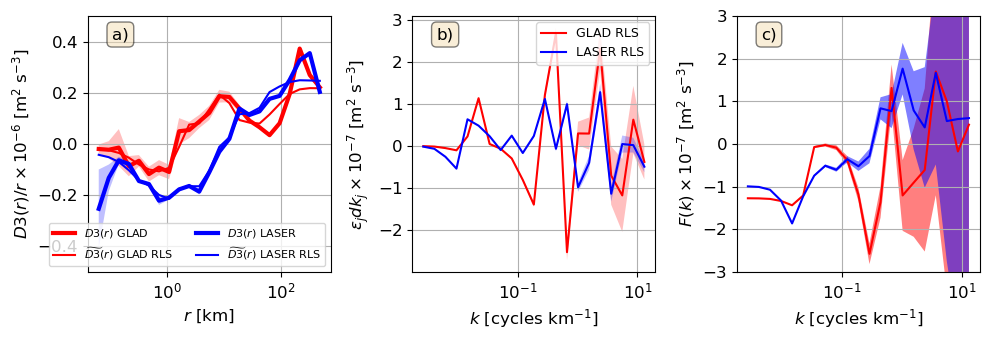

In [23]:
# Plots Paper figure

fg1, a1 = plt.subplots(1, 3, figsize=(10, 3.5))
a1[0].semilogx(distkm, du3_glad_bstr_mn/dist_all*1e6, '-r', label='$D3(r)$ GLAD',
               linewidth=3)
a1[0].fill_between(distkm, 1e6*(du3_glad_bstr_mn + du3_glad_bstr_std)/dist_all, 
                   1e6*(du3_glad_bstr_mn - du3_glad_bstr_std)/dist_all, color='r',
                   alpha=0.25, edgecolor=None)
a1[0].semilogx(distkm, V3_glad_rls/dist_all*1e6, '-r', label='$\\widetilde{D3}(r)$ GLAD RLS')
a1[0].semilogx(distkm, du3_laser_bstr_mn/dist_all*1e6, '-b', label='$D3(r)$ LASER',
               linewidth=3)
a1[0].fill_between(distkm, 1e6*(du3_laser_bstr_mn + du3_laser_bstr_std)/dist_all, 
                   1e6*(du3_laser_bstr_mn - du3_laser_bstr_std)/dist_all, color='b',
                   alpha=0.25, edgecolor=None)
a1[0].semilogx(distkm, V3_laser_rls/dist_all*1e6, '-b', label='$\\widetilde{D3}(r)$ LASER RLS')
a1[0].set_ylabel('$D3(r)/r \\times 10^{-6}$ [m$^2$ s$^{-3}$]', fontsize=12)
a1[0].set_xlabel('$r$ [km]', fontsize=12)
a1[0].text(0.1, 0.91, 'a)', transform=a1[0].transAxes, bbox=props, fontsize=12)
a1[0].tick_params(labelsize=12)
a1[0].set_ylim(-0.5, 0.5)
a1[0].legend(fontsize=8, loc=4, ncol=2)
a1[0].grid()

a1[1].semilogx(kbins_rls*1e3, eps_glad_rls_bstr[1:]*dk_rls*1e7, '-r', label='GLAD RLS')
a1[1].fill_between(kbins_rls*1e3, 1e7*(eps_glad_rls_bstr[1:] - eps_err_glad_rls_bstr[1:])*dk_rls,
                   1e7*(eps_glad_rls_bstr[1:] + eps_err_glad_rls_bstr[1:])*dk_rls, color='red', alpha=0.25,
                   edgecolor=None)
a1[1].semilogx(kbins_rls*1e3, eps_laser_rls_bstr[1:]*dk_rls*1e7, '-b', label='LASER RLS')
a1[1].fill_between(kbins_rls*1e3, 1e7*(eps_laser_rls_bstr[1:] - eps_err_laser_rls_bstr[1:])*dk_rls,
                   1e7*(eps_laser_rls_bstr[1:] + eps_err_laser_rls_bstr[1:])*dk_rls, color='blue', alpha=0.25,
                   edgecolor=None)
a1[1].set_ylabel('$\\epsilon_j dk_j\\times 10^{-7}$ [m$^2$ s$^{-3}$]', fontsize=12)
a1[1].set_xlabel('$k$ [cycles km$^{-1}$]', fontsize=12)
a1[1].tick_params(labelsize=12)
a1[1].text(0.1, 0.91, 'b)', transform=a1[1].transAxes, bbox=props, fontsize=12)
a1[1].legend(fontsize=9, loc=1)
# a1[1].set_ylim(-0.1, 0.1)
# a1[1].set_xlim(1e-3, 3e0)
a1[1].grid()

a1[2].semilogx(kbins_rls*1e3, fk_glad_rls_bstr*1e7, '-r', label='GLAD RLS')
a1[2].fill_between(kbins_rls*1e3, 1e7*(fk_glad_rls_bstr + fk_err_glad_rls_bstr), 
                   1e7*(fk_glad_rls_bstr - fk_err_glad_rls_bstr),
                   color='red', alpha=0.5, edgecolor=None)
a1[2].semilogx(kbins_rls*1e3, fk_laser_rls_bstr*1e7, '-b', label='LASER RLS')
a1[2].fill_between(kbins_rls*1e3, 1e7*(fk_laser_rls_bstr + fk_err_laser_rls_bstr), 
                   1e7*(fk_laser_rls_bstr - fk_err_laser_rls_bstr),
                   color='blue', alpha=0.5, edgecolor=None)
a1[2].set_ylabel('$F(k) \\times 10^{-7}$ [m$^2$ s$^{-3}$]', fontsize=12)
a1[2].set_xlabel('$k$ [cycles km$^{-1}$]', fontsize=12)
a1[2].text(0.1, 0.91, 'c)', transform=a1[2].transAxes, bbox=props, fontsize=12)
a1[2].tick_params(labelsize=12)
a1[2].set_ylim(-3, 3)
a1[2].grid()

fg1.tight_layout()
fg1.savefig('./FiguresMethodsPaper/fig_du3_fk_drifter_bstrp_N.png', bbox_inches = 'tight', format='png', dpi=500)

Bootstrapping yields prior uncertainty too low; regular bootstrapping assumes that each sample is independent. In reality, the drifter data per $r$ bin is a series of concantenated time series, so some autocorrelation is expected. 

# Bootstrapping known distribution functions with long tails

### Bootstrapping the errors yields unrealisticly small uncertaintity in $\delta u^3$.

### Laplace (double exponential) distribution and normal-inverse Gaussian distribution show a similar behaviour than the GLAD and LASER $\delta u^3$ long-tailed distributions.

/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


45.42162205315249
5.1324552981541665


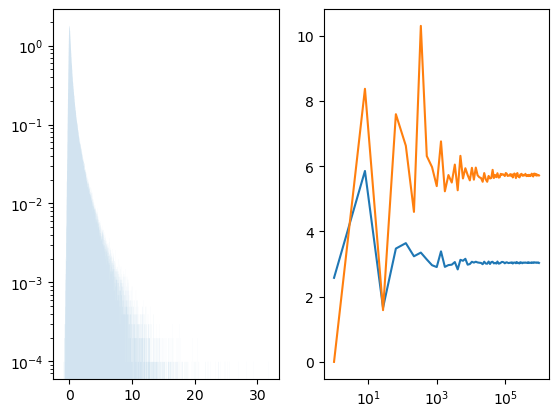

In [24]:
##### NORMAL INVERSE GAUSSIAN DISTRIBUTION

from scipy.stats import norminvgauss
a = 1
b = 0.95
mean_norminv = np.zeros((100,))
std_norminv = np.zeros((100,))
size = np.arange(0, 100)
size = size**3

for ii in range(100):
    r = norminvgauss.rvs(a, b, loc=1e-5, size=ii**3)
    mean_norminv[ii] = np.mean(r)
    std_norminv[ii] = np.std(r)
plt.subplot(1,2,1)
plt.hist(r/np.std(r), density=True, bins='auto', histtype='stepfilled', alpha=0.2)
plt.yscale('log')

plt.subplot(1,2,2)
plt.semilogx(size, mean_norminv)
plt.semilogx(size, std_norminv)

print(kurtosis(r))
print(skew(r))

In [25]:
# Normal inverse gaussian distribution
from scipy.stats import bootstrap

a = 1
b = 0.95
ninv = norminvgauss.rvs(a, b, loc=1e-6, size=10000)
rng = np.random.default_rng()

datas = (ninv,)  # samples must be in a sequence
ninv_bstr = bootstrap(datas, np.mean, confidence_level=0.9,
                       random_state=rng, method='basic')

l_bstrp, u_bstrp = np.percentile(ninv_bstr.bootstrap_distribution, [2.5, 97.5])
lower, upper = confidence_interval(ninv, ci=0.95)
lq, uq = np.percentile(ninv, [5, 95])

print('Bootstrap and data skewness: [%.4f, %.4f]' % (skew(ninv_bstr.bootstrap_distribution), skew(ninv)))
print('Bootstrap and data kurtosis: [%.4f, %.4f]' % (kurtosis(ninv_bstr.bootstrap_distribution, fisher=True), kurtosis(ninv, fisher=True)))
print('Bootstrap mean and data mean: [%.4f, %.4f]' % (np.mean(ninv_bstr.bootstrap_distribution), np.mean(ninv)))
print('Bootstrap std error and data std dev: [%.4f, %.4f]' % (np.std(ninv_bstr.bootstrap_distribution), np.std(ninv)))
print('95%% Bootstrap confidence interval: [%.4f, %.4f]' % (l_bstrp, u_bstrp))
print('95%% T-student confidence interval: [%.4f, %.4f]' % (lower, upper))
print('95%% Percentiles original: [%.4f, %.4f]' % (lq, uq))

Bootstrap and data skewness: [0.0477, 4.3635]
Bootstrap and data kurtosis: [-0.0460, 28.6396]
Bootstrap mean and data mean: [3.0472, 3.0473]
Bootstrap std error and data std dev: [0.0558, 5.5616]
95% Bootstrap confidence interval: [2.9386, 3.1571]
95% T-student confidence interval: [2.9382, 3.1563]
95% Percentiles original: [-0.4900, 12.7024]


In [26]:
# Laplace distribution

loc, scale = 1e-6, 1
lap = np.random.laplace(loc, scale, 10000)

# Bootstrapping
data0 = (lap,)  # samples must be in a sequence
lap_bstr = bootstrap(data0, np.mean, confidence_level=0.9,
                    random_state=rng, method='basic')

l_lap_bstrp, u_lap_bstrp = np.percentile(lap_bstr.bootstrap_distribution, [2.5, 97.5])

print('Bootstrap and data skewness: [%.4f, %.4f]' % (skew(lap_bstr.bootstrap_distribution), skew(lap)))
print('Bootstrap and data kurtosis: [%.4f, %.4f]' % (kurtosis(lap_bstr.bootstrap_distribution, fisher=True), kurtosis(lap, fisher=True)))
print('Bootstrap mean and data mean: [%.4f, %.4f]' % (np.mean(lap_bstr.bootstrap_distribution), np.mean(lap)))
print('Bootstrap std error and data std err: [%.4f, %.4f]' % (np.std(lap_bstr.bootstrap_distribution), np.std(lap)))
print('95%% Bootstrap confidence interval: [%.4f, %.4f]' % (l_lap_bstrp, u_lap_bstrp))

low_lap_t, up_lap_t = confidence_interval(lap, ci=0.95)
print('95%% T-student confidence interval: [%.4f, %.4f]' % (low_lap_t, up_lap_t))

llap, ulap = np.percentile(lap, [5, 95])
print('95%% Percentiles original: [%.4f, %.4f]' % (llap, ulap))

Bootstrap and data skewness: [0.0156, -0.0462]
Bootstrap and data kurtosis: [-0.0285, 2.6378]
Bootstrap mean and data mean: [0.0106, 0.0108]
Bootstrap std error and data std err: [0.0139, 1.3894]
95% Bootstrap confidence interval: [-0.0162, 0.0378]
95% T-student confidence interval: [-0.0164, 0.0381]
95% Percentiles original: [-2.2830, 2.2340]


In [27]:
# Laplace distribution 2
from arch.bootstrap import StationaryBootstrap
from arch.bootstrap import MovingBlockBootstrap

loc, scale = 1e-12, 10
lap = np.random.laplace(loc, scale, 10000)
seed = np.random.default_rng()


# Bootstrapping
data0 = (lap,)  # samples must be in a sequence
lap_bstr = bootstrap(data0, np.mean, confidence_level=0.9,
                    random_state=rng, method='basic')
nrel = 100
bsize = 10000

# Moving Block Bootstrapping
bslap = MovingBlockBootstrap(bsize, lap, seed=seed)
reslap = bslap.apply(np.mean, nrel)

l_lap_bstrp, u_lap_bstrp = np.percentile(lap_bstr.bootstrap_distribution, [2.5, 97.5])# Regular bootstrap
l_lap_movbstrp, u_lap_movbstrp = np.percentile(reslap[:, 0], [2.5, 97.5])# Block-moving bootstrap
low_lap_t, up_lap_t = confidence_interval(lap, ci=0.95)# T-student data
llap, ulap = np.percentile(lap, [5, 95])# Percentiles data

print('Bootstrap and data skewness: [%.4f, %.4f]' % (skew(lap_bstr.bootstrap_distribution), skew(lap)))
print('Bootstrap and data kurtosis: [%.4f, %.4f]' % (kurtosis(lap_bstr.bootstrap_distribution, fisher=True), kurtosis(lap, fisher=True)))
print('Bootstrap mean and data mean: [%.4f, %.4f]' % (np.mean(lap_bstr.bootstrap_distribution), np.mean(lap)))
print('Bootstrap std error and data std err: [%.4f, %.4f]' % (np.std(lap_bstr.bootstrap_distribution), np.std(lap)))
print('95%% Bootstrap confidence interval: [%.4f, %.4f]' % (l_lap_bstrp, u_lap_bstrp))
print('95%% Block-moving Bootstrap confidence interval: [%.4f, %.4f]' % (l_lap_movbstrp, u_lap_movbstrp))
print('95%% T-student confidence interval: [%.4f, %.4f]' % (low_lap_t, up_lap_t))
print('95%% Percentiles original: [%.4f, %.4f]' % (llap, ulap))



Bootstrap and data skewness: [0.0053, -0.0483]
Bootstrap and data kurtosis: [-0.0033, 2.7834]
Bootstrap mean and data mean: [-0.2329, -0.2326]
Bootstrap std error and data std err: [0.1396, 13.9972]
95% Bootstrap confidence interval: [-0.5045, 0.0420]
95% Block-moving Bootstrap confidence interval: [-0.2326, -0.2326]
95% T-student confidence interval: [-0.5069, 0.0418]
95% Percentiles original: [-23.2856, 22.5324]


# Moving block bootstrap

### Using ordinary bootstrapping yields unrealisticly small errors in the third-order structure function, thus small errors in the cross-scale transfers $F(k)$ and injection rates $\epsilon$. This is because data presents a temporal correlation such that each data point is not independent from others.

## An alternative methodology for estimating standard errros is moving block bootstrapping:

##### For moving-block bootstrapping, we construct a pseudo-time series of $\delta u3(r,t)$ for each $r$ bin from several concatenated time series of different pairs of drifters. The concatenated records inherently have some autocorrelation because of the spatio-temporal proximity between pairs. Then we divided the concatenated $\delta u3(r,t)$ data for each $r$ bin into overlapping blocks of data of size $L(r)/N(r)$, where $L(r)$ is the length of the concatenated data per $r$ bin and $N(r)$ is the number degrees of freedom. Here, $N(r)$ is roughly estimated by dividing the total duration of each drifter experiment by the decorrelation timescale at each $r$, which was calculated with the help of $D2(r)$. Next, we sample $b$ blocks with replacement at each $r$ and concatenate them to construct a pseudo-time series of $\delta u3(r,t)$ of length $L(r)$. The mean of this pair-sample set gives a bootstrap estimate of $D3(r)$ ($D3_b(r)$). We repeat this step 2000 times to ensure that the bootstrap estimates $D3(r)_b$ are Gaussian-distributed per central limit theorem \citep{stroock2010probability}.


We employ arch 6.3.0 by Sheppard et al (2021) to perform the moving block bootstrapping. The software is available in Zenodo (https://doi.org/10.5281/zenodo.593254) and in (https://arch.readthedocs.io/en/latest/index.html).

## Some tests

In [28]:
du3g = laser_dul[10]**3 + laser_dut[10]**2*laser_dul[10]

In [29]:
Nblk = round(dof_laser[10])
blksiz = round(len(du3g)/Nblk)

In [30]:
seed = np.random.default_rng()

# Stationary Block Bootstrapping
bs = StationaryBootstrap(blksiz, du3g, seed=seed)
results = bs.apply(np.mean, 2000)

# Moving Block Bootstrapping
bs1 = MovingBlockBootstrap(blksiz, du3g, seed=seed)
results1 = bs1.apply(np.mean, 2000)

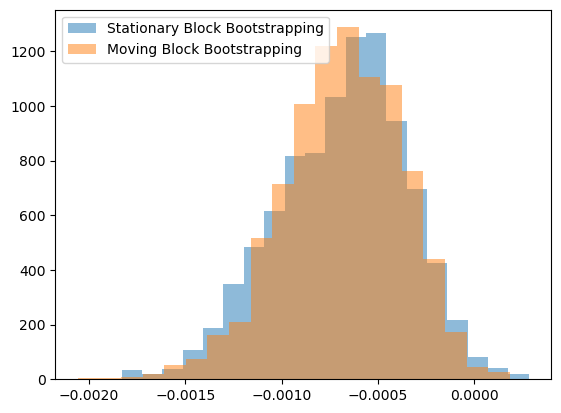

In [31]:
plt.hist(results[:, -1:], bins=20, density=True, alpha=0.5, label='Stationary Block Bootstrapping')
plt.hist(results1[:, -1:], bins=20, density=True, alpha=0.5, label='Moving Block Bootstrapping')
plt.legend()

In [32]:
# Calculates mean, std err, skewness and (excess of) kurtosis
mean_bbstrp = np.mean(results[:, -1:])
std_bbstrp = np.std(results[:, -1:])
mean_movbbstrp = np.mean(results1[:, -1:])
std_movbbstrp = np.std(results1[:, -1:])

print('### Data statistics ###')
print('Mean $\\pm$ std. err = %0.5f $\\pm$ %0.5f' % (np.nanmean(du3g), np.nanstd(du3g)))
print('Skewness = %0.2f' % skew(du3g))
print('Kurtosis = %0.2f' % kurtosis(du3g, fisher=True))
print('\n')
print('### Ordinary Bootstrap ###')
print('Mean $\\pm$ std. err = %0.5f $\\pm$ %0.5f' % (du3_laser_bstr_mn[10], du3_laser_bstr_std[10]))
print('Skewness = %0.2f' % skew(du3_laser_bstr[10, :]))
print('Kurtosis = %0.2f' % kurtosis(du3_laser_bstr[10, :], fisher=True))
print('\n')
print('### Stationary Block Bootstrap ###')
print('Mean $\\pm$ std. err = %0.5f $\\pm$ %0.5f' % (mean_bbstrp, std_bbstrp))
print('Skewness = %0.2f' % skew(results[:, -1:]))
print('Kurtosis = %0.2f' % kurtosis(results[:, -1:], fisher=True))
print('\n')
print('### Moving Block Bootstrap ###')
print('Mean $\\pm$ std. err = %0.5f $\\pm$ %0.5f' % (mean_movbbstrp, std_movbbstrp))
print('Skewness = %0.2f' % skew(results1[:, -1:]))
print('Kurtosis = %0.2f' % kurtosis(results1[:, -1:], fisher=True))


### Data statistics ###
Mean $\pm$ std. err = -0.00068 $\pm$ 0.09641
Skewness = -48.23
Kurtosis = 488229.44


### Ordinary Bootstrap ###
Mean $\pm$ std. err = -0.00068 $\pm$ 0.00004
Skewness = 0.02
Kurtosis = 0.01


### Stationary Block Bootstrap ###
Mean $\pm$ std. err = -0.00068 $\pm$ 0.00034
Skewness = -0.34
Kurtosis = -0.02


### Moving Block Bootstrap ###
Mean $\pm$ std. err = -0.00068 $\pm$ 0.00031
Skewness = -0.35
Kurtosis = 0.23


## Estimating std errors in $D3(r)$ using moving block bootstrapping

In [46]:
njobs = 30
nrep = 2000

mvblstrap_glad = np.zeros((nrep, len(dist_all)))
mvblstrap_laser = mvblstrap_glad*0.

def movingblock_bootstrap_parallel(ii):
    du3g = glad_dul[ii][:, 0]**3 + glad_dut[ii][:, 0]**2*glad_dul[ii][:, 0]
    du3l = laser_dul[ii]**3 + laser_dut[ii]**2*laser_dul[ii]

    Nblk_g = round(dof_glad[ii])
    blksiz_g = round(len(du3g)/Nblk_g)
    Nblk_l = round(dof_laser[ii])
    blksiz_l = round(len(du3l)/Nblk_l)

    bsg = MovingBlockBootstrap(blksiz_g, du3g, seed=seed)
    blstrap_glad = bsg.apply(np.mean, nrep)[:, 0]

    bsl = MovingBlockBootstrap(blksiz_l, du3l, seed=seed)
    blstrap_laser = bsl.apply(np.mean, nrep)[:, 0]

    return blstrap_glad, blstrap_laser

# Use Parallel and delayed to parallelize
results = Parallel(n_jobs=njobs)(delayed(movingblock_bootstrap_parallel)(ii) for ii in tqdm(range(len(dist_all))))

# Unpack results
for ii, (mvglad, mvlaser) in tqdm(enumerate(results)):
    mvblstrap_glad[:, ii] = mvglad
    mvblstrap_laser[:, ii] = mvlaser

100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 4747.02it/s]
23it [00:00, 27258.83it/s]


In [34]:
# Calculates Gaussian curve for bootstrapped data
iu = 3
il = 18

D3bx = 0.4
D3b_bins = np.arange(-12, 12, D3bx)

glad_norm0 = norm.pdf(D3b_bins, np.mean(mvblstrap_glad[:, iu])/np.std(mvblstrap_glad[:, iu]), 1)
glad_norm1 = norm.pdf(D3b_bins, np.mean(mvblstrap_glad[:, il])/np.std(mvblstrap_glad[:, il]), 1)
laser_norm0 = norm.pdf(D3b_bins, np.mean(mvblstrap_laser[:, iu])/np.std(mvblstrap_laser[:, iu]), 1)
laser_norm1 = norm.pdf(D3b_bins, np.mean(mvblstrap_laser[:, il])/np.std(mvblstrap_laser[:, il]), 1)

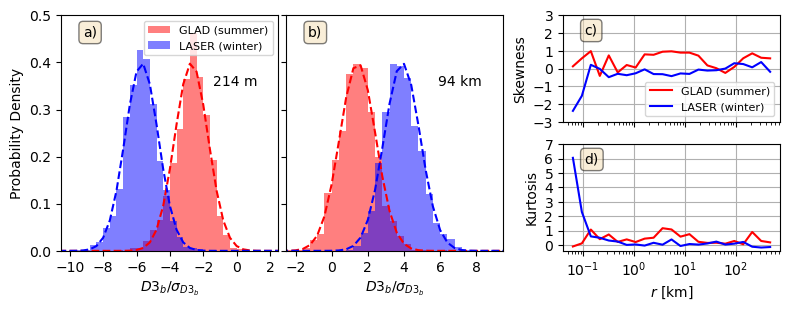

In [35]:
from matplotlib import gridspec
gs = gridspec.GridSpec(3, 4, width_ratios=[1, 1, 0.2, 1])


fiu = plt.figure(figsize=(8, 4))

plt.subplot(gs[0:2, 0])
plt.hist(mvblstrap_glad[:, iu]/np.std(mvblstrap_glad[:, iu]), 
         bins=D3b_bins, alpha=0.5, density=True, color='red', label='GLAD (summer)')
plt.plot(D3b_bins, glad_norm0, '--r')
plt.hist(mvblstrap_laser[:, iu]/np.std(mvblstrap_laser[:, iu]), 
         bins=D3b_bins, alpha=0.5, density=True, color='blue', label='LASER (winter)')
plt.plot(D3b_bins, laser_norm0, '--b')
plt.ylim(0, 0.5)
plt.gca().set_xticks(np.arange(-12, 6, 2))
plt.xlim(-10.5, 2.5)
plt.ylabel('Probability Density')
plt.xlabel('$D3_b/\\sigma_{D3_b}$')
plt.text(0.1, 0.91, 'a)', transform=plt.gca().transAxes, bbox=props)
plt.text(0.7, 0.7, "{} m".format(round(dist_all[iu])), transform=plt.gca().transAxes)
plt.legend(fontsize=8, loc=1)

plt.subplot(gs[0:2, 1])
plt.hist(mvblstrap_glad[:, il]/np.std(mvblstrap_glad[:, il]), 
         bins=D3b_bins, alpha=0.5, density=True, color='red')
plt.plot(D3b_bins, glad_norm1, '--r')
plt.hist(mvblstrap_laser[:, il]/np.std(mvblstrap_laser[:, il]), 
         bins=D3b_bins, alpha=0.5, density=True, color='blue')
plt.plot(D3b_bins, laser_norm1, '--b')
plt.gca().set_yticklabels([])
plt.gca().set_xticks(np.arange(-2, 12, 2))
plt.ylim(0, 0.5)
plt.xlim(-2.5, 9.5)
plt.xlabel('$D3_b/\\sigma_{D3_b}$')
plt.text(0.1, 0.91, 'b)', transform=plt.gca().transAxes, bbox=props)
plt.text(0.7, 0.7, "{} km".format(round(distkm[il])), transform=plt.gca().transAxes)


plt.subplot(gs[0:2, 2])
plt.gca().set_visible(False)


plt.subplot(gs[0:1, 3])
plt.semilogx(dist_all*1e-3, skew(mvblstrap_glad, axis=0), '-r', label='GLAD (summer)')
plt.semilogx(dist_all*1e-3, skew(mvblstrap_laser, axis=0), '-b', label='LASER (winter)')
plt.ylim(-3, 3)
plt.gca().set_xticklabels([])
plt.gca().set_xticks([0.1, 1, 10, 100])
plt.gca().set_yticks(np.arange(-3, 4, 1))
plt.ylabel('Skewness')
plt.text(0.1, 0.82, 'c)', transform=plt.gca().transAxes, bbox=props)
plt.legend(fontsize=8, loc=4)
plt.grid()


plt.subplot(gs[1:2, 3])
plt.semilogx(dist_all*1e-3, kurtosis(mvblstrap_glad, fisher=True, axis=0), '-r')
plt.semilogx(dist_all*1e-3, kurtosis(mvblstrap_laser, fisher=True, axis=0), '-b')
plt.ylim(-0.4, 6.8)
plt.gca().set_xticks([0.1, 1, 10, 100])
plt.gca().set_yticks(np.arange(0, 8, 1))
plt.grid()
plt.xlabel('$r$ [km]')
plt.ylabel('Kurtosis')
plt.text(0.1, 0.82, 'd)', transform=plt.gca().transAxes, bbox=props)


plt.tight_layout(w_pad=-3, h_pad=-2)
fiu.savefig('./FiguresMethodsPaper/fig_D3b_kurt_movBstr_N.png', bbox_inches = 'tight', format='png', dpi=500)

## Non-negative least-squares fitting of the moving block bootstrapped samples

Both $k$ and $r$ are equally spaced in log spaced following Balwada et al. 2022

In [36]:
# Non-negative least-squares on each bootstrapped mean
eps_glad_nnls_mvbbstr = np.zeros((nrep, len(kbins_nn)+1))
eps_laser_nnls_mvbbstr = eps_glad_nnls_mvbbstr*0.
Fk_glad_nnls_mvbbstr = np.zeros((nrep, len(kbins_nn)))
Fk_laser_nnls_mvbbstr = Fk_glad_nnls_mvbbstr*0.
V3_glad_nnls_mvbbstr = np.zeros((nrep, len(dist_all)))
V3_laser_nnls_mvbbstr = V3_glad_nnls_mvbbstr*0.


for ii in tqdm(range(nrep)):
    # Non-negative LS
    eps_glad_nnls_mvbbstr[ii, :] = nnls(Ann, mvblstrap_glad[ii, :]/dist_all)[0]
    eps_laser_nnls_mvbbstr[ii, :] = nnls(Ann, mvblstrap_laser[ii, :]/dist_all)[0]
    
    V3_glad_nnls_mvbbstr[ii, :] = np.dot(Ann, eps_glad_nnls_mvbbstr[ii, :]) # reconstructed V3
    V3_laser_nnls_mvbbstr[ii, :] = np.dot(Ann, eps_laser_nnls_mvbbstr[ii, :]) # reconstructed V3
    
    # Calculate energy cascade
    Fk_glad_nnls_mvbbstr[ii, :] = calcFk(eps_glad_nnls_mvbbstr[ii, :], kbins_nn, dk_nn)
    Fk_laser_nnls_mvbbstr[ii, :] = calcFk(eps_laser_nnls_mvbbstr[ii, :], kbins_nn, dk_nn)
    
eps_err_glad_nnls_mvbbstr = np.std(eps_glad_nnls_mvbbstr, axis=0) #errors in eps
eps_err_laser_nnls_mvbbstr = np.std(eps_glad_nnls_mvbbstr, axis=0) #errors in eps
Fk_err_glad_nnls_mvbbstr = np.std(Fk_glad_nnls_mvbbstr, axis=0)# errors in F(k)
Fk_err_laser_nnls_mvbbstr = np.std(Fk_laser_nnls_mvbbstr, axis=0)# errors in F(k)

  0%|          | 0/2000 [00:00<?, ?it/s]

## Regularized Least-Squares using moving block bootstrapp errors

Bootstrapped samples are interpolated to linear-spaced $r$ bins. $k$ bins are also linearly spaced.

In [37]:
def weight_function(xint, x):
    # Check the weight type and compute the corresponding weights
    dist = np.abs(xint[:, None] - x)
    weights = 1 / (dist + 1e-10)  # Add small epsilon to avoid division by zero
    
    # Normalize the weights so that they sum to 1
    weights /= np.sum(weights, axis=1, keepdims=True)
    return weights

# Defines new r bins
dr = 100
rbins = np.arange(min(dist_all), max(dist_all), dr)

# Mean and std error of mvb bootstrapped samples
glad_D3b_mean = np.mean(mvblstrap_glad, axis=0)
glad_D3b_std = np.std(mvblstrap_glad, axis=0)

laser_D3b_mean = np.mean(mvblstrap_laser, axis=0)
laser_D3b_std = np.std(mvblstrap_laser, axis=0)

# Interpolation for the mean
fglad = sp.interpolate.interp1d(dist_all, glad_D3b_mean)
sf3_glad_mvbbstr = fglad(rbins)

flaser = sp.interpolate.interp1d(dist_all, laser_D3b_mean)
sf3_laser_mvbbstr = flaser(rbins)

# Interpolation for the standard deviation
fglad_std = sp.interpolate.interp1d(dist_all, glad_D3b_std)
sf3_glad_std_mvbbstr = fglad_std(rbins)

flaser_std = sp.interpolate.interp1d(dist_all, laser_D3b_std)
sf3_laser_std_mvbbstr = flaser_std(rbins)

# # Calculate weighted standard deviation for each rbin -- SAME for GLAD and LASER
# weights = weight_function(rbins, dist_all)

# # Weighted std deviation
# sf3_glad_std_mvbbstr = np.sum(weights * glad_D3b_std, axis=1)
# sf3_laser_std_mvbbstr = np.sum(weights * laser_D3b_std, axis=1)

63.28125


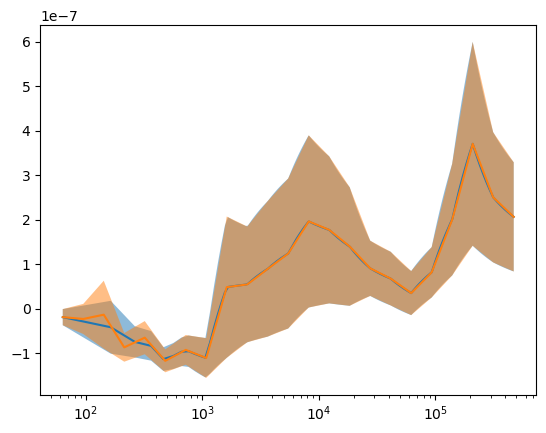

In [38]:
plt.semilogx(rbins, sf3_glad_mvbbstr/rbins)
plt.fill_between(rbins, (sf3_glad_mvbbstr + sf3_glad_std_mvbbstr)/rbins, 
                 (sf3_glad_mvbbstr - sf3_glad_std_mvbbstr)/rbins, alpha=0.5)
plt.semilogx(dist_all, glad_D3b_mean/dist_all)
plt.fill_between(dist_all, (glad_D3b_mean - glad_D3b_std)/dist_all, (glad_D3b_mean + glad_D3b_std)/dist_all,
            alpha=0.5)
print(dist_all.min())

In [39]:
# Define weight matrix
dk_mvb = 1/max(rbins)
kbins_mvb = np.arange(1/max(rbins), 1/(2*dr), 1/max(rbins))

# Prior uncertainty D3(r)
W_glad_mvbbstr = np.diag(sf3_glad_std_mvbbstr**2)#[indi:indf])
W_laser_mvbbstr = np.diag(sf3_laser_std_mvbbstr**2)#[indi:indf])

# Prior uncertainty \epsilon_u and \epsilon_j
fac = 1e-05
fac_epsj_mvb = 0.5e-6

# GLAD
P_glad_mvbbstr = np.concatenate(([fac], np.ones((len(kbins_mvb),))*fac_epsj_mvb), axis=0)
P_glad_mvbbstr = np.diag(P_glad_mvbbstr)

# LASER
P_laser_mvbbstr = np.concatenate(([fac], np.ones((len(kbins_mvb),))*fac_epsj_mvb), axis=0)
P_laser_mvbbstr = np.diag(P_laser_mvbbstr)

# Defines H
Amvb = defA(rbins, kbins_mvb, dk_mvb*np.ones((len(kbins_mvb))))
print(Amvb.shape)

# Least squares
eps_glad_rls_mvbbstr, V3_glad_rls_mvbbstr, res_glad_rls_mvbbstr, cxx_glad_rls_mvbbstr = RLS(sf3_glad_mvbbstr, W_glad_mvbbstr, P_glad_mvbbstr, Amvb)    
eps_laser_rls_mvbbstr, V3_laser_rls_mvbbstr, res_laser_rls_mvbbstr, cxx_laser_rls_mvbbstr = RLS(sf3_laser_mvbbstr, W_laser_mvbbstr, P_laser_mvbbstr, Amvb)

# Injection rates errors
eps_err_glad_rls_mvbbstr = np.sqrt(np.diag(cxx_glad_rls_mvbbstr))
eps_err_laser_rls_mvbbstr = np.sqrt(np.diag(cxx_laser_rls_mvbbstr))

# Cross-scale flux
fk_glad_rls_mvbbstr = calcFk(eps_glad_rls_mvbbstr, kbins_mvb, dk_mvb*np.ones((len(kbins_mvb))))
fk_laser_rls_mvbbstr = calcFk(eps_laser_rls_mvbbstr, kbins_mvb, dk_mvb*np.ones((len(kbins_mvb))))

# Energy flux errors
Herr_mvb = defH(kbins_mvb, dk_mvb*np.ones((len(kbins_mvb))))
fk_err_glad_rls_mvbbstr = np.sqrt(np.diag(errorsFlux(cxx_glad_rls_mvbbstr, Herr_mvb)))
fk_err_laser_rls_mvbbstr = np.sqrt(np.diag(errorsFlux(cxx_laser_rls_mvbbstr, Herr_mvb)))

eigval_cxx_glad_rls_mvbbstr, eigvec_cxx_glad_rls_mvbbstr = np.linalg.eig(cxx_glad_rls_mvbbstr)
eigval_cxx_laser_rls_mvbbstr, eigvec_cxx_laser_rls_mvbbstr = np.linalg.eig(cxx_laser_rls_mvbbstr)


(4734, 2367)


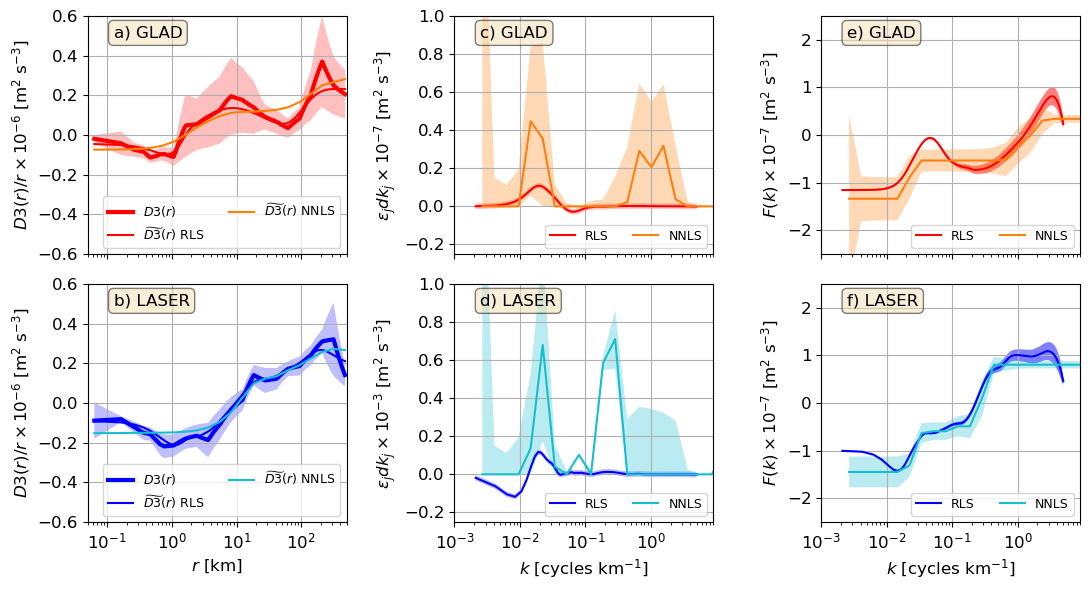

In [40]:
# Plots Paper figure

fg5, a5 = plt.subplots(2, 3, figsize=(11, 6))

# Errors
erru_eps_glad_nnls_mvbbstr = np.nanmean(eps_glad_nn, axis=1) + eps_err_glad_nnls_mvbbstr
errl_eps_glad_nnls_mvbbstr = np.nanmean(eps_glad_nn, axis=1) - eps_err_glad_nnls_mvbbstr
errl_eps_glad_nnls_mvbbstr = np.maximum(errl_eps_glad_nnls_mvbbstr, 0)


erru_eps_laser_nnls_mvbbstr = np.nanmean(eps_laser_nn, axis=1) + eps_err_laser_nnls_mvbbstr
errl_eps_laser_nnls_mvbbstr = np.nanmean(eps_laser_nn, axis=1) - eps_err_laser_nnls_mvbbstr
errl_eps_laser_nnls_mvbbstr = np.maximum(errl_eps_laser_nnls_mvbbstr, 0)


a5[0, 0].semilogx(rbins*1e-3, sf3_glad_mvbbstr/rbins*1e6, '-r', label='$D3(r)$',
              linewidth=3)
a5[0, 0].fill_between(rbins*1e-3, 1e6*(sf3_glad_mvbbstr + sf3_glad_std_mvbbstr)/rbins, 
                   1e6*(sf3_glad_mvbbstr - sf3_glad_std_mvbbstr)/rbins, color='r',
                   alpha=0.25, edgecolor=None)
a5[0, 0].semilogx(rbins*1e-3, V3_glad_rls_mvbbstr/rbins*1e6, '-r', 
                  label='$\\widetilde{D3}(r)$ RLS')
a5[0, 0].semilogx(distkm, np.nanmean(V3_glad_nnls_mvbbstr, axis=0)*1e6, 
               '-', color='#ff7f00', label='$\\widetilde{D3}(r)$ NNLS')
a5[0, 0].set_ylabel('$D3(r)/r \\times 10^{-6}$ [m$^2$ s$^{-3}$]', fontsize=12)
# a5[0, 0].set_xlabel('$r$ [km]', fontsize=12)
a5[0, 0].set_xticklabels([])
a5[0, 0].text(0.1, 0.91, 'a) GLAD', transform=a5[0, 0].transAxes, bbox=props, fontsize=12)
a5[0, 0].tick_params(labelsize=12)
a5[0, 0].set_ylim(-0.6, 0.6)
a5[0, 0].set_xlim(0.5e-1, 5e2)
a5[0, 0].legend(fontsize=9, loc=4, ncol=2)
a5[0, 0].grid()


a5[1, 0].semilogx(rbins*1e-3, sf3_laser_mvbbstr/rbins*1e6, '-b', label='$D3(r)$',
              linewidth=3)
a5[1, 0].fill_between(rbins*1e-3, 1e6*(sf3_laser_mvbbstr + sf3_laser_std_mvbbstr)/rbins, 
                   1e6*(sf3_laser_mvbbstr - sf3_laser_std_mvbbstr)/rbins, color='b',
                   alpha=0.25, edgecolor=None)
a5[1, 0].semilogx(rbins*1e-3, V3_laser_rls_mvbbstr/rbins*1e6, '-b', label='$\\widetilde{D3}(r)$ RLS')
a5[1, 0].semilogx(distkm, np.nanmean(V3_laser_nnls_mvbbstr, axis=0)*1e6, 
                  '-', color='#17BECF', label='$\\widetilde{D3}(r)$ NNLS')
a5[1, 0].set_xlabel('$r$ [km]', fontsize=12)
a5[1, 0].text(0.1, 0.91, 'b) LASER', transform=a5[1, 0].transAxes, bbox=props, fontsize=12)
a5[1, 0].set_ylabel('$D3(r)/r \\times 10^{-6}$ [m$^2$ s$^{-3}$]', fontsize=12)
a5[1, 0].tick_params(labelsize=12)
a5[1, 0].set_ylim(-0.6, 0.6)
a5[1, 0].set_xlim(0.5e-1, 5e2)
a5[1, 0].legend(fontsize=9, loc=4, ncol=2)
a5[1, 0].grid()


a5[0, 1].semilogx(kbins_mvb*1e3, eps_glad_rls_mvbbstr[1:]*1e7*dk_mvb, '-r', label='RLS')
a5[0, 1].fill_between(kbins_mvb*1e3, 1e7*(eps_glad_rls_mvbbstr[1:] - eps_err_glad_rls_mvbbstr[1:])*dk_mvb,
                      1e7*(eps_glad_rls_mvbbstr[1:]+ (eps_err_glad_rls_mvbbstr[1:]))*dk_mvb, 
                      color='red', alpha=0.25, edgecolor=None)
a5[0, 1].semilogx(kbins_nn*1e3, np.nanmean(eps_glad_nn[1:, :], axis=1)*1e7*dk_nn, '-', 
                  color='#FF7F0E', label='NNLS')
a5[0, 1].fill_between(kbins_nn*1e3, 1e7*erru_eps_glad_nnls_mvbbstr[1:]*dk_nn,
                      1e7*errl_eps_glad_nnls_mvbbstr[1:]*dk_nn, 
                      color='#FF7F0E', alpha=0.3, edgecolor=None)
a5[0, 1].set_ylabel('$\\epsilon_j dk_j\\times 10^{-7}$ [m$^2$ s$^{-3}$]', fontsize=12)
# a5[0, 1].set_xlabel('$k$ [cycles km$^{-1}$]', fontsize=12)
a5[0, 1].set_xticklabels([])
a5[0, 1].tick_params(labelsize=12)
a5[0, 1].text(0.1, 0.91, 'c) GLAD', transform=a5[0, 1].transAxes, bbox=props, fontsize=12)
a5[0, 1].legend(fontsize=9, loc=4, ncol=2)
a5[0, 1].set_ylim(-0.25, 1)
a5[0, 1].set_xlim(1e-3, 9e0)
a5[0, 1].grid()

a5[1, 1].semilogx(kbins_mvb*1e3, eps_laser_rls_mvbbstr[1:]*1e7*dk_mvb, '-b', label='RLS')
a5[1, 1].fill_between(kbins_mvb*1e3, 1e7*(eps_laser_rls_mvbbstr[1:] - eps_err_laser_rls_mvbbstr[1:])*dk_mvb,
                      1e7*(eps_laser_rls_mvbbstr[1:]+ (eps_err_laser_rls_mvbbstr[1:]))*dk_mvb, 
                      color='blue', alpha=0.25, edgecolor=None)
a5[1, 1].semilogx(kbins_nn*1e3, np.nanmean(eps_laser_nn[1:, :], axis=1)*1e7*dk_nn, '-', 
                  color='#17BECF', label='NNLS')
a5[1, 1].fill_between(kbins_nn*1e3, 1e7*erru_eps_laser_nnls_mvbbstr[1:]*dk_nn,
                      1e7*errl_eps_laser_nnls_mvbbstr[1:]*dk_nn, 
                      color='#17BECF', alpha=0.3, edgecolor=None)
a5[1, 1].set_xlabel('$k$ [cycles km$^{-1}$]', fontsize=12)
a5[1, 1].set_ylabel('$\\epsilon_j dk_j\\times 10^{-3}$ [m$^2$ s$^{-3}$]', fontsize=12)
a5[1, 1].tick_params(labelsize=12)
a5[1, 1].text(0.1, 0.91, 'd) LASER', transform=a5[1, 1].transAxes, bbox=props, fontsize=12)
a5[1, 1].legend(fontsize=9, loc=4, ncol=2)
a5[1, 1].set_ylim(-0.25, 1)
a5[1, 1].set_xlim(1e-3, 9e0)
a5[1, 1].grid()

a5[0, 2].semilogx(kbins_mvb*1e3, fk_glad_rls_mvbbstr*1e7, '-r', label='RLS')
a5[0, 2].fill_between(kbins_mvb*1e3, 1e7*(fk_glad_rls_mvbbstr + fk_err_glad_rls_mvbbstr), 
                   1e7*(fk_glad_rls_mvbbstr-fk_err_glad_rls_mvbbstr),
                   color='red', alpha=0.5, edgecolor=None)
a5[0, 2].semilogx(kbins_nn*1e3, 1e7*np.nanmean(fk_glad_nn, axis=1), '-', 
               color='#FF7F0E', label='NNLS')
a5[0, 2].fill_between(kbins_nn*1e3, 1e7*(np.nanmean(fk_glad_nn, axis=1) + Fk_err_glad_nnls_mvbbstr),
                   1e7*(np.nanmean(fk_glad_nn, axis=1) - Fk_err_glad_nnls_mvbbstr), 
                   color='#FF7F0E', alpha=0.3, edgecolor=None)
a5[0, 2].set_ylabel('$F(k) \\times 10^{-7}$ [m$^2$ s$^{-3}$]', fontsize=12)
a5[0, 2].text(0.1, 0.91, 'e) GLAD', transform=a5[0, 2].transAxes, bbox=props, fontsize=12)
a5[0, 2].set_xticklabels([])
a5[0, 2].tick_params(labelsize=12)
a5[0, 2].set_xlim(1e-3, 9e0)
a5[0, 2].legend(fontsize=9, loc=4, ncol=2)
a5[0, 2].set_ylim(-2.5, 2.5)
a5[0, 2].grid()

a5[1, 2].semilogx(kbins_mvb*1e3, fk_laser_rls_mvbbstr*1e7, '-b', label='RLS')
a5[1, 2].fill_between(kbins_mvb*1e3, 1e7*(fk_laser_rls_mvbbstr + fk_err_laser_rls_mvbbstr), 
                      1e7*(fk_laser_rls_mvbbstr-fk_err_laser_rls_mvbbstr),
                      color='blue', alpha=0.5, edgecolor=None)
a5[1, 2].semilogx(kbins_nn*1e3, 1e7*np.nanmean(fk_laser_nn, axis=1), '-', 
                  color='#17BECF', label='NNLS')
a5[1, 2].fill_between(kbins_nn*1e3, 1e7*(np.nanmean(fk_laser_nn, axis=1) + Fk_err_laser_nnls_mvbbstr),
                      1e7*(np.nanmean(fk_laser_nn, axis=1) - Fk_err_laser_nnls_mvbbstr), 
                      color='#17BECF', alpha=0.3, edgecolor=None)
a5[1, 2].set_ylabel('$F(k) \\times 10^{-7}$ [m$^2$ s$^{-3}$]', fontsize=12)
a5[1, 2].set_xlabel('$k$ [cycles km$^{-1}$]', fontsize=12)
a5[1, 2].text(0.1, 0.91, 'f) LASER', transform=a5[1, 2].transAxes, bbox=props, fontsize=12)
a5[1, 2].tick_params(labelsize=12)
a5[1, 2].set_xlim(1e-3, 9e0)
a5[1, 2].legend(fontsize=9, loc=4, ncol=2)
a5[1, 2].set_ylim(-2.5, 2.5)
a5[1, 2].grid()

fg5.tight_layout()
fg5.savefig('./FiguresMethodsPaper/fig_D3_fk_drifter_movingblockbstrp_N.png', bbox_inches = 'tight', format='png', dpi=500)

##### TESTS CHECKING EIGENVALUES AND EIGENVECTORS, AND OTHER METRICS

/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


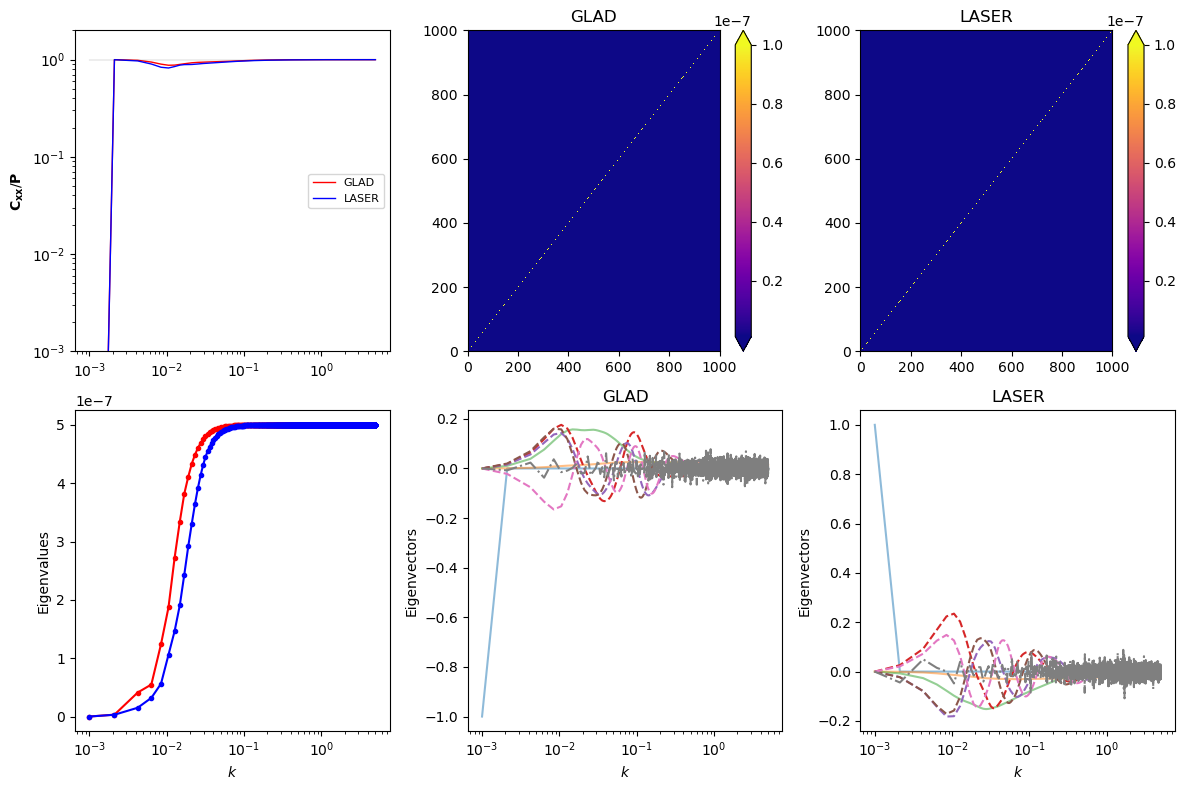

In [41]:
fig8, ax8 = plt.subplots(2, 3, figsize=(12, 8))

x1, x2 = np.meshgrid(np.concatenate(([1e-6], kbins_mvb)), np.concatenate(([1e-6], kbins_mvb)))

ax8[0, 0].loglog(np.concatenate(([1e-6], kbins_mvb))*1e3, np.diag(cxx_glad_rls_mvbbstr)/np.diag(P_glad_mvbbstr), '-r', 
                 linewidth=1, label='GLAD')
ax8[0, 0].loglog(np.concatenate(([1e-6], kbins_mvb))*1e3, np.diag(cxx_laser_rls_mvbbstr)/np.diag(P_laser_mvbbstr), '-b', 
                 linewidth=1, label='LASER')
ax8[0, 0].loglog([1e-3, max(kbins_mvb)*1e3], [1, 1], color='black', linewidth=0.1)
ax8[0, 0].set_ylabel('$\\mathbf{C_{xx}}/\\mathbf{P}$')
ax8[0, 0].set_ylim(1e-3, 2e0)
ax8[0, 0].legend(fontsize=8, loc=5)

cs8 = ax8[0, 1].pcolormesh(cxx_glad_rls_mvbbstr[:1000,:1000], cmap='plasma', vmin=1e-9, vmax=1e-7)
ax8[0, 1].set_title('GLAD')
plt.colorbar(cs8, ax=ax8[0, 1], extend='both')

cs9 = ax8[0, 2].pcolormesh(cxx_laser_rls_mvbbstr[:1000,:1000], cmap='plasma', vmin=1e-9, vmax=1e-7)
ax8[0, 2].set_title('LASER')
plt.colorbar(cs9, ax=ax8[0, 2], extend='both')

ax8[1, 0].plot(np.concatenate(([1e-6], kbins_mvb))*1e3, np.sort(eigval_cxx_glad_rls_mvbbstr), '.-r')
ax8[1, 0].plot(np.concatenate(([1e-6], kbins_mvb))*1e3, np.sort(eigval_cxx_laser_rls_mvbbstr), '.-b')
ax8[1, 0].set_xscale('log')
ax8[1, 0].set_ylabel('Eigenvalues')
ax8[1, 0].set_xlabel('$k$')

ax8[1, 1].semilogx(np.concatenate(([1e-6], kbins_mvb))*1e3, eigvec_cxx_glad_rls_mvbbstr[:, :3], '-', alpha=0.5)
ax8[1, 1].semilogx(np.concatenate(([1e-6], kbins_mvb))*1e3, eigvec_cxx_glad_rls_mvbbstr[:, 6:10], '--')
ax8[1, 1].semilogx(np.concatenate(([1e-6], kbins_mvb))*1e3, eigvec_cxx_glad_rls_mvbbstr[:, -1], '-.')
ax8[1, 1].set_ylabel('Eigenvectors')
ax8[1, 1].set_xlabel('$k$')
ax8[1, 1].set_title('GLAD')

ax8[1, 2].semilogx(np.concatenate(([1e-6], kbins_mvb))*1e3, eigvec_cxx_laser_rls_mvbbstr[:, :3], '-', alpha=0.5)
ax8[1, 2].semilogx(np.concatenate(([1e-6], kbins_mvb))*1e3, eigvec_cxx_laser_rls_mvbbstr[:, 6:10], '--')
ax8[1, 2].semilogx(np.concatenate(([1e-6], kbins_mvb))*1e3, eigvec_cxx_laser_rls_mvbbstr[:, -1], '-.')
ax8[1, 2].set_ylabel('Eigenvectors')
ax8[1, 2].set_xlabel('$k$')
ax8[1, 2].set_title('LASER')

fig8.tight_layout()

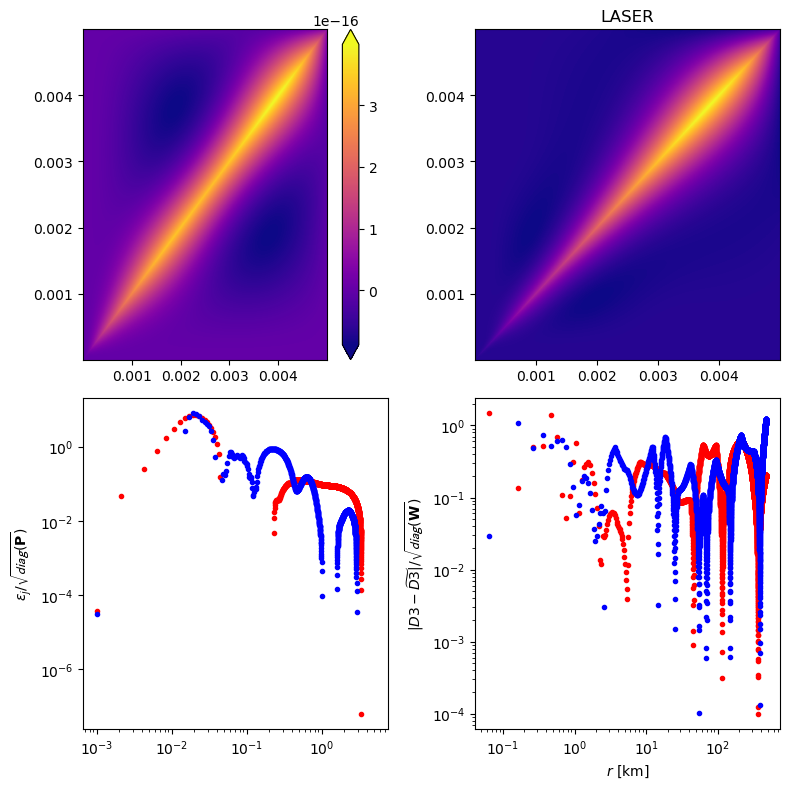

In [42]:
### CHECKING ERROR PROPAGATION 

fig9, ax9 = plt.subplots(2, 2, figsize=(8, 8), sharex=False, sharey=False)
cm9 = ax9[0, 0].pcolormesh(x1, x2, errorsFlux(cxx_glad_rls_mvbbstr, Herr_mvb), cmap='plasma')
plt.colorbar(cm9, ax=ax9[0, 0], extend='both')
ax5[0, 0].set_title('GLAD')
# ax5[0].set_yscale('log')
# ax5[0].set_xscale('log')

cm10 = ax9[0, 1].pcolormesh(x1, x2, errorsFlux(cxx_laser_rls_mvbbstr, Herr_mvb), cmap='plasma')
plt.colorbar(cm2, ax=ax5[0, 1], extend='both')
ax9[0, 1].set_title('LASER')
# ax5[1].set_yscale('log')
# ax5[1].set_xscale('log')

ax9[1, 0].loglog(np.concatenate(([1e-6], kbins_mvb))*1e3, eps_glad_rls_mvbbstr/np.sqrt(np.diag(P_glad_mvbbstr)), '.r')
ax9[1, 0].loglog(np.concatenate(([1e-6], kbins_mvb))*1e3, eps_laser_rls_mvbbstr/np.sqrt(np.diag(P_laser_mvbbstr)), '.b')
ax9[1, 0].set_ylabel('$\\epsilon_j/\\sqrt{\\mathcal{diag}(\\mathbf{P}}}$)')
ax9[1, 1].set_xlabel('$k$ [cycles km$^{-1}$]')


ax9[1, 1].loglog(rbins*1e-3, abs(res_glad_rls_mvbbstr)/np.sqrt(np.diag(W_glad_mvbbstr)), '.r')
ax9[1, 1].loglog(rbins*1e-3, abs(res_laser_rls_mvbbstr)/np.sqrt(np.diag(W_laser_mvbbstr)), '.b')
ax9[1, 1].set_ylabel('$|D3-\\widetilde{D3}|/\\sqrt{\\mathcal{diag}(\\mathbf{W}}}$)')
ax9[1, 1].set_xlabel('$r$ [km]')

fig9.tight_layout()